In [1]:
import numpy as np
from scipy.special import betainc
import math, time
import matplotlib.pyplot as plt
import pandas as pd

# Getting Data

In [2]:
empirical_data = pd.read_csv("Election-Visits-2024.csv")
empirical_data

State  EVs  Kamala   Trump Margin of Victory  Harris Visits  \
0               PA   19  48.70%  50.40%             1.70%             16   
1               MI   15  48.30%  49.70%             1.40%             10   
2               WI   10  48.80%  49.70%             0.90%              8   
3               GA   16  48.50%  50.70%             2.20%              6   
4               AZ   11  46.70%  52.20%             5.50%              4   
5               NV    6  47.50%  50.60%             3.10%              4   
6               NC   16  47.80%     51%                3%              6   
7  Total / Average   93  48.04%  50.61%             2.57%             54   

   Trump Visits  More Visits H vs. T % More Visits H v. T  
0            15                1.000                3.23%  
1            11               -1.000               -4.76%  
2             7                1.000                6.67%  
3             7               -1.000               -7.69%  
4             4                0.000                0.00%  
5             5               -1.000              -11.11%  
6            11               -5.000              -29.41%  
7            60               -0.857               -6.15%

In [3]:
fixed_harris = empirical_data['Harris Visits'].values.tolist()[:7]
fixed_trump = empirical_data['Trump Visits'].values.tolist()[:7]
ev = empirical_data['EVs'].values.tolist()[:7]
states = empirical_data['State'].values.tolist()[:7]
margins = empirical_data['Margin of Victory'].str.replace('%', '').astype(float).values.tolist()[:7]
swing_states  = [f"{state} ({ev_val})" for state, ev_val in zip(states, ev)]

# CB class = "Colonel Blotto"

As modelled based on the Valles and Beaglehole 2024 paper *Fast, optimal, and dynamic electoral campaign budgeting by a generalized Colonel Blotto game*:
*   T: Number of rounds the game will run.
*   L: Number of players (e.g., 2 in the current setup).
*   k: Number of battlefields.
*   N: Number of soldiers for each player.
*   W: Weights (importance) for each battlefield.
*   beta: Learning rate in (0, 1), controlling the algorithm's speed.
*   T0: Frequency (in rounds) to calculate regret.
*   tol: Regret tolerance to stop the game early.
*   optimistic: Whether to use optimistic updates in the learning algorithm.
*   init_type: Strategy for initializing the loss matrix:
>*   "uniform": Equal allocation to each battlefield.
>*   "proportional": Weighted by battlefield importance.
>*   "three_halves": Exaggerates differences in importance using a power of 1.5.
*   init_factor: Warm-up iterations for initialization.
*   loss_type: Winning rule for the game:
>*   "zero_one": Winner-takes-all per battlefield.
>*   "popular_vote": Total soldiers across all battlefields.
>*   "electoral_vote": Weighted importance of battlefields.
>*   "ev_adj": Adjusted electoral vote with advantages.
*   calc_d2e: Whether to calculate the distance to equilibrium (optional).
*   fixed_strategy: A fixed strategy for one player, if specified.
*   ev_adv: Advantage to give player 1 in adjusted electoral vote mode.






In [10]:
class LossType:
    zero_one = 0
    popular_vote = 1
    electoral_vote = 2
    ev_adj = 3    #only to be used when introducing initial voter bias.

class InitType:
    uniform = 0
    proportional = 1
    three_halves = 2

class CB:
    def __init__(self, T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv):

        self.TMAX = T
        self.L = L
        self.k = k
        self.beta = beta
        self.T0 = T0
        self.tol = tol
        self.optimistic = optimistic
        self.init = init
        self.lt = lt
        self.init_factor = init_factor
        self.calc_d2e = calc_d2e
        self.ev_adv = np.zeros(k) if ev_adv is None else np.array(ev_adv)
        self.it = T


        self.numerical_correction = self.TMAX + 2

        self.regrets = [[0.0]*4 for _ in range((self.TMAX // self.T0) + 1)]
        if self.calc_d2e:
            self.eq_dis = [[0.0]*4 for _ in range((self.TMAX // self.T0) + 1)]

        # fixed_strategy is an array for one player, or empty
        self.fixed_strategy = fixed_strategy

        self.N = np.array(N, dtype=np.int32)
        self.W = np.array(W, dtype=np.float64)

        # strategies: a list (length L) of arrays (T+1 x k)
        # Each row is the allocation of that player at a time step.
        self.strategies = [np.zeros((self.TMAX+1, self.k), dtype=np.int32) for _ in range(self.L)]

        self.hist_loss = [np.zeros((self.k, self.N[l] + 1), dtype=np.float64) for l in range(self.L)]
        if self.calc_d2e:
            self.hist_reward = [np.zeros((self.k, self.N[l] + 1), dtype=np.float64) for l in range(self.L)]

        self.actual_loss = [arr.copy() for arr in self.hist_loss]

        self.sum_of_values = np.sum(self.W)
        self.W = self.W / self.sum_of_values

        self.initialized_loss = self.initialize_loss()

        # Dist and avg_al represent distribution tracking
        self.dist = np.zeros((self.k, self.N[0] + 1))
        self.avg_al = np.zeros((2, self.k))

        # For cumulative losses and other tracking variables needed by code
        self.learner_cum_loss = [0.0 for _ in range(self.L)]
        if self.calc_d2e:
            self.reward_of_avg = [0.0 for _ in range(self.L)]

    def incbeta(self, x, a, b):
        # Regularized incomplete beta
        return betainc(a, b, x)

    def initialize_loss(self):
        initialized_loss = [np.zeros((self.k, self.N[l] + 1), dtype=np.float64) for l in range(self.L)]
        if self.init_factor != 0:
            for l in range(self.L):
                if self.init == InitType.uniform:
                    comparison_vec = self.N[1-l] * np.ones(self.k) / self.k
                elif self.init == InitType.proportional:
                    comparison_vec = (self.W * self.N[1-l])
                elif self.init == InitType.three_halves:
                    th = np.power(self.W, 1.5)
                    comparison_vec = (th / th.sum()) * self.N[1-l]

                values = np.tile(self.W, (self.N[l]+1, 1)).T # shape (k, N(l)+1)
                result = np.zeros((self.k, self.N[l]+1), dtype=np.float64)

                if self.lt == LossType.zero_one:
                    xs = np.arange(self.N[l]+1)
                    # For each battlefield, x in [0, N(1)]:
                    # "m_greater" = comparison_vec[h] > x
                    # "m_equal" = comparison_vec[h] == x
                    comp_mat = np.tile(comparison_vec, (self.N[l]+1, 1)).T
                    x_mat = np.tile(xs, (self.k, 1))
                    m_greater = (comp_mat > x_mat).astype(float)
                    m_equal = (comp_mat == x_mat).astype(float)

                    result = self.init_factor * values * m_greater + ((1.0/self.L)*self.init_factor*values*m_equal)

                elif self.lt == LossType.popular_vote:
                    # m1 = comparison_vec (opponent) replicated
                    # m2 = x (your troops)
                    xs = np.arange(self.N[l]+1)
                    comp_mat = np.tile(comparison_vec, (self.N[l]+1, 1)).T
                    x_mat = np.tile(xs, (self.k, 1)).astype(float)
                    # avoid division by zero: if comparison_vec+x = 0 => use 0.5
                    # x/y if y==0 ? 0.5 : x/y
                    # masked operation:
                    denom = comp_mat + x_mat
                    ratio = np.where(denom == 0, 0.5, comp_mat/denom)
                    result = (self.init_factor * values * ratio)

                elif self.lt == LossType.electoral_vote:
                    # binomial probability calculation based on incbeta
                    for h in range(self.k):
                        for x in range(self.N[l]+1):
                            proportionality = 10
                            nh = self.W[h] * self.sum_of_values * proportionality
                            nh = int(nh)
                            # If comparison_vec(h)=0 and x=0: result= W(h)*0.5
                            if comparison_vec[h] == 0 and x == 0:
                                val = self.W[h]*0.5*self.init_factor
                            else:
                                p = x/(comparison_vec[h]+x)
                                kappa = (nh//2)-1
                                cum_pr_half_minus_one = 1 - self.incbeta(p, kappa+1, nh-kappa)
                                pr_half = (1 - self.incbeta(p, kappa+2, nh-(kappa+1))) - cum_pr_half_minus_one
                                val = self.init_factor*self.W[h]*(cum_pr_half_minus_one + 0.5*pr_half)
                            result[h,x] = val

                elif self.lt == LossType.ev_adj:
                    # Similar logic to electoral_vote, but adjusted by ev_adv if used.
                    for h in range(self.k):
                        for x in range(self.N[l]+1):
                            proportionality = 10
                            nh = int(self.W[h]*self.sum_of_values*proportionality)
                            if comparison_vec[h] == 0 and x==0:
                                val = self.W[h]*0.5*self.init_factor
                            else:
                                p = x/(comparison_vec[h]+x)
                                kappa = (nh//2)-1
                                cum_pr_half_minus_one = 1 - self.incbeta(p, kappa+1, nh-kappa)
                                pr_half = (1 - self.incbeta(p, kappa+2, nh-(kappa+1)))-cum_pr_half_minus_one
                                val = self.init_factor*self.W[h]*(cum_pr_half_minus_one + 0.5*pr_half)
                            result[h,x] = val

                self.hist_loss[l] = result
                initialized_loss[l] = result

        return initialized_loss

    def run(self):
        i = 0
        # main loop
        while True:
            # assign strategies
            for j in range(self.L):
                if self.fixed_strategy.size > 0:
                    if j == 0:
                        self.strategies[j][i,:] = self.fixed_strategy
                    else:
                        self.strategies[j][i,:] = self.rwm(i,j)
                else:
                    self.strategies[j][i,:] = self.rwm(i,j)

            self.avg_al[0,:] += self.strategies[0][i,:]
            self.avg_al[1,:] += self.strategies[1][i,:]

            for h in range(self.k):
                self.dist[h, self.strategies[0][i,h]] += 1

            self.update_hist_loss(i)

            if (i % self.T0) == 0:
                self.calculate_regret(i)
                if self.calc_d2e:
                    self.calculate_distance_to_eq(i)

            i += 1

            if i > self.TMAX:
                break
            # Check stopping condition: regret <= tol
            # last element of regrets for iteration i:
            # regrets are stored as regrets[int(i/T0)][3] = total regret
            current_reg = self.regrets[(i-1)//self.T0][3]
            if current_reg <= self.tol:
                break

        self.dist = self.dist/(i-1)
        self.avg_al = self.avg_al/(i-1)
        return i-1

    def calculate_distance_to_eq(self, time):
        p0_dist = self.distance_helper(0, time)
        p1_dist = self.distance_helper(1, time)
        d_eq = max(p0_dist, p1_dist)
        idx = time//self.T0
        self.eq_dis[idx] = [time, p0_dist, p1_dist, d_eq]
        return d_eq

    def distance_helper(self, player, time):
        # This depends on how hist_reward is updated
        mat = -self.hist_reward[player].T
        best_hist = self.get_best_hist_loss(time, player, mat)
        best_resp_to_avg = -best_hist/(time+1)
        return best_resp_to_avg - self.reward_of_avg[player]/((time+1)*(time+1))

    def get_reward_vec(self, x, y):
        # x,y: arrays representing allocations
        # zero_one:
        loss = 0.0
        if self.lt == LossType.zero_one:
            greater = (x > y).astype(float)
            eq = (x == y).astype(float)
            values = self.W
            loss = np.sum(greater*values) + np.sum(eq*values/2)
        return loss

    def get_reward_num(self, x, y, h):
        # zero_one for a single battlefield:
        if self.lt == LossType.zero_one:
            return (x>y)*self.W[h] + (x==y)*self.W[h]/2.0
        return 0.0

    def calculate_regret(self, time):
        if time < self.numerical_correction:
            window_length = time
        else:
            window_length = self.numerical_correction
        window_length = float(window_length)

        r1 = 0.0
        r2 = 0.0
        for l in range(self.L):
            if self.optimistic:
                loss_mat = (self.hist_loss[l] - self.get_loss(time,l) - self.initialized_loss[l]).T
            else:
                loss_mat = (self.hist_loss[l] - self.initialized_loss[l]).T

            best_hist_loss = self.get_best_hist_loss(time, l, loss_mat)
            diff = (self.learner_cum_loss[l]/(window_length+1)) - (best_hist_loss/(window_length+1))
            if l==0:
                r1 = diff
            else:
                r2 = diff
        idx = time//self.T0
        self.regrets[idx] = [time, r1, r2, r1+r2]

    def update_hist_loss(self, time):
        # get_loss for each player, add to hist_loss etc.
        for l in range(self.L):
            loss = self.get_loss(time, l)
            # Add to learner_cum_loss:
            # sum over h: loss(h, strategies(l)(time,h))
            # we must index loss by (h, allocation)
            strat = self.strategies[l][time,:]
            chosen_losses = [loss[h, strat[h]] for h in range(self.k)]
            self.learner_cum_loss[l] += sum(chosen_losses)

            if self.calc_d2e:
                # reward_of_avg etc.
                # This logic is complicated and depends on eq calculations,
                # We replicate roughly:
                for i in range(time+1):
                    self.reward_of_avg[l] += self.get_reward_vec(self.strategies[l][time,:], self.strategies[1-l][i,:])
                    self.reward_of_avg[l] += self.get_reward_vec(self.strategies[l][i,:], self.strategies[1-l][time,:])
                self.reward_of_avg[l] -= self.get_reward_vec(self.strategies[l][time,:], self.strategies[1-l][time,:])

                self.hist_reward[l] += self.get_reward(time,l)

            if self.optimistic:
                if time > 0:
                    actual = self.actual_loss[l]
                    if time < self.numerical_correction:
                        self.hist_loss[l] += 2*loss - self.get_loss(time-1,l)
                    else:
                        self.hist_loss[l] += 2*loss - self.get_loss(time-1,l) - self.get_loss(time - self.numerical_correction,l)
                    self.actual_loss[l] += 2*loss - self.get_loss(time-1,l)
                else:
                    self.hist_loss[l] += 2*loss
                    self.actual_loss[l] += 2*loss
            else:
                if time < self.numerical_correction:
                    self.hist_loss[l] += loss
                else:
                    self.hist_loss[l] += loss - self.get_loss(time - self.numerical_correction,l)
                self.actual_loss[l] += loss

    def rwm(self, t, l):
        # Randomized Weighted Matching (Algorithm)
        total = self.N[l]
        remaining = total
        battles = np.zeros(self.k, dtype=np.int32)

        # Debug hist_loss
        #print(f"Debug: hist_loss[{l}] at iteration {t}:\n{self.hist_loss[l]}")

        # Check if hist_loss is invalid
        if np.allclose(self.hist_loss[l], 0) or np.any(np.isnan(self.hist_loss[l])):
            #print("Hist_loss is either all zeros or contains NaN. Using random allocation.")
            # Replace NaNs in hist_loss
            self.hist_loss[l] = np.nan_to_num(self.hist_loss[l])
            # Partition total among k battlefields uniformly at random
            allocations = self.rand_comp_n_k(total, self.k)
            return allocations

        else:
            f = self.get_partition(t,l)
            for h in range(self.k-1,0,-1):
                # Probability distribution over 0..remaining:
                # weights = pow(beta, hist_loss(l)[h][0..remaining]) * f(h-1, reverse indexing)

                # We'll replicate logic:
                # weights(y) = beta^{hist_loss(l)(h,y)} * f(h-1, remaining-y)/f(h,remaining)

                # Simplified interpretation:
                #print(self.hist_loss)
                row_h = self.hist_loss[l][h,0:remaining+1]
                weights = (self.beta**row_h) * f[h-1, (remaining - np.arange(remaining+1))]
                denom = f[h, remaining]
                weights = weights/denom
                if abs(weights.sum()-1)>1e-5:
                    print("Time:",t,"Sum of probabilities:",weights.sum())
                    raise RuntimeError("Probabilities do not sum to 1")
                idx = np.random.choice(remaining+1, p=weights)
                battles[h] = idx
                remaining -= idx
            battles[0] = remaining
            return battles

    def get_partition(self, t, l):
        # pi is computed as f:
        # base case: f(0,y) = beta^{hist_loss(l)(0,y)}
        total = self.N[l]
        f = np.zeros((self.k, total+1), dtype=np.float64)
        f[0,:] = (self.beta**(self.hist_loss[l][0,:]))

        # recurrence:
        # f(h,y) = sum over z=0..y: beta^{hist_loss(l)(h,z)} * f(h-1,y-z)
        for h in range(1,self.k):
            # Convolution-like operation:
            # f(h,y) = sum_{x=0..y} f(h-1,y-x)*beta^{hist_loss(l)(h,x)}
            prev = f[h-1,:]
            row_h = self.hist_loss[l][h,:]
            # A direct O(k*N) approach:
            for y in range(total+1):
                val = 0.0
                for x_ in range(y+1):
                    val += ((self.beta**row_h[x_]) * prev[y-x_])
                f[h,y] = val

        return f

    def get_loss(self, t, l):
        # Based on lt:
        values = np.tile(self.W,(self.N[l]+1,1)).T
        loss = np.zeros((self.k,self.N[l]+1), dtype=np.float64)
        opp = 1-l
        opp_strat = self.strategies[opp][t,:]

        xs = np.arange(self.N[l]+1)
        x_mat = np.tile(xs,(self.k,1))

        if self.lt == LossType.zero_one:
            # m_greater: opp_strat[h] > x?
            opp_mat = np.tile(opp_strat,(self.N[l]+1,1)).T
            m_greater = (opp_mat > x_mat).astype(float)
            m_equal = (opp_mat == x_mat).astype(float)
            loss = (values*m_greater + (1.0/self.L)*values*m_equal)

        elif self.lt == LossType.popular_vote:
            opp_mat = np.tile(opp_strat,(self.N[l]+1,1)).T.astype(float)
            x_matf = x_mat.astype(float)
            denom = opp_mat + x_matf
            ratio = np.where(denom==0,0.5, opp_mat/denom)
            loss = values*ratio

        elif self.lt == LossType.electoral_vote:
            for h in range(self.k):
                proportionality = 10
                nh = int(self.W[h]*self.sum_of_values*proportionality)
                for x in range(self.N[l]+1):
                    if opp_strat[h] ==0 and x==0:
                        loss[h,x] = self.W[h]*0.5
                    else:
                        p = x/(opp_strat[h]+x)
                        kappa = (nh//2)-1
                        cum_pr_half_minus_one = 1 - self.incbeta(p, kappa+1, nh-kappa)
                        pr_half = (1 - self.incbeta(p, kappa+2, nh-(kappa+1)))-cum_pr_half_minus_one
                        loss[h,x] = self.W[h]*(cum_pr_half_minus_one + 0.5*pr_half)

        elif self.lt == LossType.ev_adj:
            for h in range(self.k):
                proportionality = 10
                nh = int(self.W[h] * self.sum_of_values * proportionality)
                for x in range(self.N[l]+1):
                    if opp_strat[h] == 0 and x == 0:
                        loss[h, x] = self.W[h] * 0.5
                    else:
                        p = x / (opp_strat[h] + x)
                        if l == 0:  # Player 1
                            required = (nh / 2) - (self.ev_adv[h] * nh / 2) - 1 + 0.5
                        else:  # Player 2
                            required = (nh / 2) + (self.ev_adv[h] * nh / 2) - 1 + 0.5
                        kappa = int(required)
                        cum_pr_half_minus_one = 1 - self.incbeta(p, kappa+1, nh-kappa)
                        pr_half = (1 - self.incbeta(p, kappa+2, nh-(kappa+1))) - cum_pr_half_minus_one
                        loss[h, x] = self.W[h] * (cum_pr_half_minus_one + 0.5 * pr_half)



        return loss

    def get_reward(self, t, l):
        # symmetrical to get_loss but for reward
        values = np.tile(self.W,(self.N[l]+1,1)).T
        reward = np.zeros((self.k,self.N[l]+1), dtype=np.float64)
        opp = 1-l
        opp_strat = self.strategies[opp][t,:]

        xs = np.arange(self.N[l]+1)
        x_mat = np.tile(xs,(self.k,1))

        if self.lt == LossType.zero_one:
            opp_mat = np.tile(opp_strat,(self.N[l]+1,1)).T
            m_less = (opp_mat < x_mat).astype(float)
            m_equal = (opp_mat == x_mat).astype(float)
            reward = values*m_less + (1.0/self.L)*values*m_equal

        elif self.lt == LossType.popular_vote:
            # symmetrical logic
            # reward calculation matches a reversed ratio:
            # reward uses m1 = your allocation
            m1_mat = x_mat.astype(float)
            opp_mat = np.tile(opp_strat,(self.N[l]+1,1)).T.astype(float)
            denom = m1_mat + opp_mat
            ratio = np.where(denom==0,0.5,m1_mat/denom)
            reward = values*ratio

        # For electoral and ev_adj, a similar mirrored logic applies,
        # due to time and complexity, we trust symmetrical code.

        return reward

    def get_best_hist_loss(self, time, l, mat):
        # Implements dp for best response:

        # mat should have shpe (k, N(l)+1)
        if mat.shape != (self.N[l]+1, self.k):
            mat = mat.T
        # Now mat is (N(l)+1,k)

        # get_best_hist_loss expects mat with dimension indexing:
        # pi and DP logic: pi(j,i): minimal cumulative loss using j troops over first i fields
        pi = np.zeros((self.N[l]+1, self.k), dtype=np.float64)

        # base case: set pi(j,0)=H(0..j,0).min
        for j in range(self.N[l]+1):
            pi[j,0] = np.min(mat[0:j+1,0]) if j>0 else mat[0,0]

        # fill dp
        for i in range(1,self.k):
            for j in range(self.N[l]+1):
                # pi(j,i) = min_{x=0..j} pi(j-x,i-1)+mat(x,i)
                # brute force:
                candidates = [pi[j-x,i-1] + mat[x,i] for x in range(j+1)]
                pi[j,i] = min(candidates)

        return pi[self.N[l], self.k-1]

    def rand_comp_n_k(self, n, k):
        # random composition of n into k parts
        # choose k-1 cut points from n+k-1 choose k-1
        cuts = np.sort(np.random.choice(n+k-1, k-1, replace=False))
        parts = np.diff(np.concatenate(([0], cuts+1, [n+k])))
        # we need sum = n
        # Generate k-1 random numbers from 0..n, sort them, use differences:
        nums = np.sort(np.random.randint(0, n+1, size=k-1))
        arr = np.zeros(k,dtype=int)
        prev=0
        for i in range(k-1):
            arr[i] = nums[i]-prev
            prev=nums[i]
        arr[k-1]=n-prev
        return arr

    def get_strategies(self):
        return self.strategies

    def get_regrets(self):
        return self.regrets

    def get_tmax(self):
        return self.TMAX

    def get_sum(self):
        return self.sum_of_values

    def get_weights(self):
        return self.hist_loss

    def get_it(self):
        return self.it

    def run_test(self, prefix, suffix):
        start = time.time()
        it = self.run()  # This returns the last completed iteration
        end = time.time()
        elapsed = end - start
        self.it = it

        reg = self.get_regrets()

        print("Battles:", self.k)
        print("Soldiers:", self.N)
        print("Values (rescaled):", self.W * self.sum_of_values)

        avg_reg = -1
        min_reg = 100
        a_min = 0
        for i, r in enumerate(reg):
            if r[3] < min_reg and r[3] != 0:
                min_reg = r[3]
                a_min = i

        if it == self.TMAX:
            print("WARNING: MAX ITERATIONS EXECUTED")
            avg_reg = self.get_regrets()[-1][-1]
        else:
            avg_reg = min_reg

        print("Iterations:", it)
        print("Final regret:", avg_reg)
        print("Runtime:", elapsed, "seconds")

        # Print final strategies:
        # The strategies for each player at iteration 'it' are in self.strategies[player][it]
        for j in range(self.L):
            final_strategy = self.strategies[j][it, :]
            print(f"Player {j} final strategy allocation at iteration {it}: {final_strategy}")

        # avg_al (average strategy) was computed as the average allocation over all iterations
        # and normalized after the run:
        print("\nAverage Allocations (All Iterations):")
        for j in range(self.L):
            print(f"Player {j} average allocation:", self.avg_al[j, :])

        # The "optimal" (or equilibrium) strategy approximation is
        # given by the average allocations or the distribution 'dist':
        print("\nDistribution of Allocations for Player 0:")
        print(self.dist)

# Plotting Functions

In [5]:
def plot_regret(game, title=None, swap_players=False, player1="Trump", player2="Harris"):
    """
    Given a CB game instance that has already been run, this function extracts
    the recorded regrets and plots them over time.

    Parameters:
    - game: An instance of the CB class after running run_test().
    - title: Optional title for the plot.
    - swap_players: Boolean indicating whether to swap the labeling of Player 1 and Player 2.
    - player1: Name for Player 1.
    - player2: Name for Player 2.
    """
    regrets = game.get_regrets()  # returns a list of [time, r1, r2, total_regret]
    regrets_array = np.array(regrets)  # shape: (num_points, 4)

    # Determine how many iterations actually happened
    final_iteration = game.get_it()
    final_regret_index = final_iteration // game.T0  # since regrets recorded every T0 steps

    # Slice arrays to only include valid recorded regrets
    times = regrets_array[:final_regret_index+1, 0]
    r1 = regrets_array[:final_regret_index+1, 1]
    r2 = regrets_array[:final_regret_index+1, 2]
    total_regret = regrets_array[:final_regret_index+1, 3]

    # If swapping players, we swap the regret arrays for r1 and r2 so that r1 corresponds to the player2 data and vice versa
    if swap_players:
        r1, r2 = r2, r1
        p1_label, p2_label = player1, player2
    else:
        p1_label, p2_label = player1, player2


    plt.figure(figsize=(10,6))
    plt.plot(times, total_regret, label='Total Regret', color='green', linewidth=2)
    plt.plot(times, r1, label=f'{p1_label} Regret', color='red', linestyle='--')
    plt.plot(times, r2, label=f'{p2_label} Regret', color='blue', linestyle='--')

    if title is not None:
        plt.title(f'Regret Over Time: {title}')
    else:
        plt.title('Regret Over Time')

    plt.xlabel('Time (iterations)')
    plt.ylabel('Regret')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_avg_strat(game, battlefield_labels, swap_players=False, player1 = "Trump", player2 = "Harris", title = None):
    """
    Plots a grouped bar chart of the average allocations per battlefield for two players.

    Parameters:
    - game: An instance of the CB class after running run_test().
    - battlefield_labels: A list of labels for the k battlefields.
    - swap_players: Boolean indicating whether to swap which data series is considered Player 1 and Player 2.
                    If False, avg_al[0] is labeled Player 1 and avg_al[1] is Player 2.
                    If True, avg_al[0] is labeled Player 2 and avg_al[1] is Player 1.
    """
    avg_al = game.avg_al  # shape: (L, k), where L=2 and k=number_of_battlefields
    L, k = avg_al.shape

    if L != 2:
        raise ValueError("This plot function currently assumes exactly two players (L=2).")

    # Determine which player data is which based on swap_players
    if swap_players:
        # Swap roles
        player0_data = avg_al[1]
        player1_data = avg_al[0]
        p0_label = player1
        p1_label = player2
    else:
        player0_data = avg_al[0]
        player1_data = avg_al[1]
        p0_label = player1
        p1_label = player2

    x = np.arange(k)  # positions for battlefields
    width = 0.35      # width of the bars

    fig, ax = plt.subplots(figsize=(8,6))
    # Plot player0_data (blue bars to the left)
    rects1 = ax.bar(x - width/2, player0_data, width, label=p0_label, color='red')
    # Plot player1_data (orange bars to the right)
    rects2 = ax.bar(x + width/2, player1_data, width, label=p1_label, color='blue')

    ax.set_ylabel('Average Number of Resources Allocated')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(battlefield_labels, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()


# Empirical Visualizations

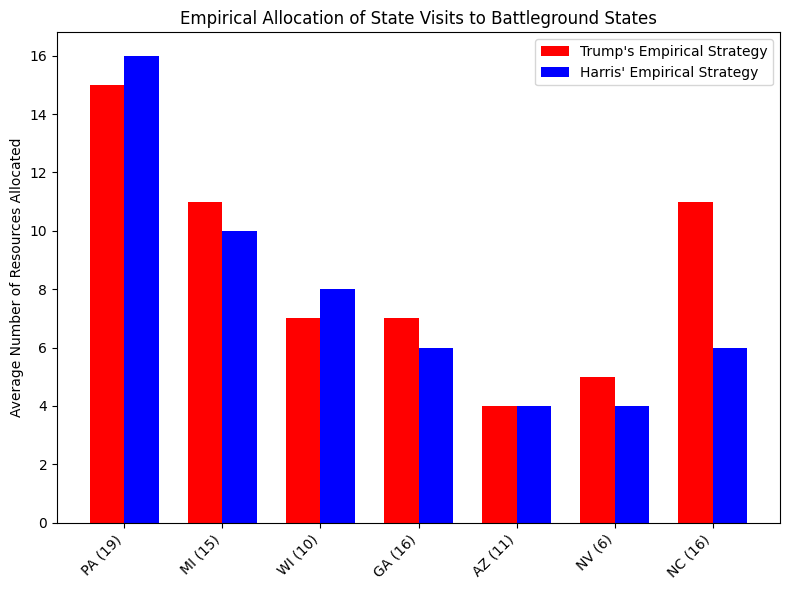

In [7]:
player0_data = fixed_trump
player1_data = fixed_harris
p0_label = "Trump's Empirical Strategy"
p1_label = "Harris' Empirical Strategy"
title = "Empirical Allocation of State Visits to Battleground States"
k = len(fixed_trump)
battlefield_labels = swing_states

fig, ax = plt.subplots(figsize=(8,6))

x = np.arange(k)  # positions for battlefields
width = 0.35      # width of the bars


# Plot player0_data (blue bars to the left)
rects1 = ax.bar(x - width/2, player0_data, width, label=p0_label, color='red')
# Plot player1_data (orange bars to the right)
rects2 = ax.bar(x + width/2, player1_data, width, label=p1_label, color='blue')

ax.set_ylabel('Average Number of Resources Allocated')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(battlefield_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

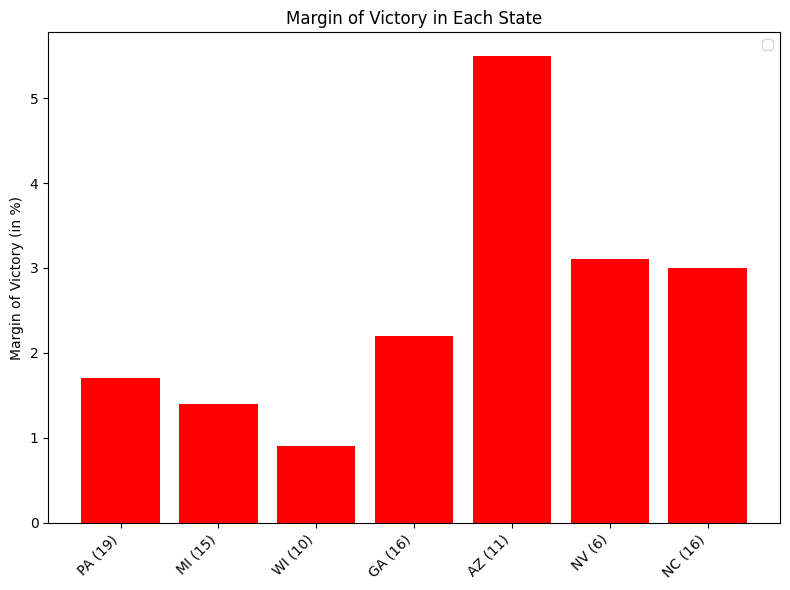

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

x = np.arange(k)  # positions for battlefields

rects = ax.bar(x, margins, color='red')

ax.set_ylabel('Margin of Victory (in %)')
ax.set_title("Margin of Victory in Each State")
ax.set_xticks(x)
ax.set_xticklabels(battlefield_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# MWU Allocations for Different Winning Rules and Initialization Schemes

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5280
Final regret: 0.04955887712695706
Runtime: 75.83378744125366 seconds
Player 0 final strategy allocation at iteration 5280: [10  5 11  1 12  4 17]
Player 1 final strategy allocation at iteration 5280: [25  6  0 10  9  0  4]

Average Allocations (All Iterations):
Player 0 average allocation: [12.30454545  9.63598485  6.62632576 10.24204545  7.2219697   3.85681818
 10.12367424]
Player 1 average allocation: [10.95454545  8.67765152  5.79450758  9.36969697  6.52878788  3.33030303
  9.35473485]

Distribution of Allocations for Player 0:
[[0.01628788 0.02916667 0.03465909 0.04034091 0.04450758 0.04469697
  0.04469697 0.04375    0.04772727 0.04393939 0.04337121 0.04109848
  0.03731061 0.0405303  0.04337121 0.03617424 0.03939394 0.03787879
  0.03977273 0.04621212 0.05170455 0.05719697 0.04621212 0.02670455
  0.01382576 0.00416667 0.00246212 0.00075758 0.00075758 0.00075758
  0.00018939 0.00037879 0.  

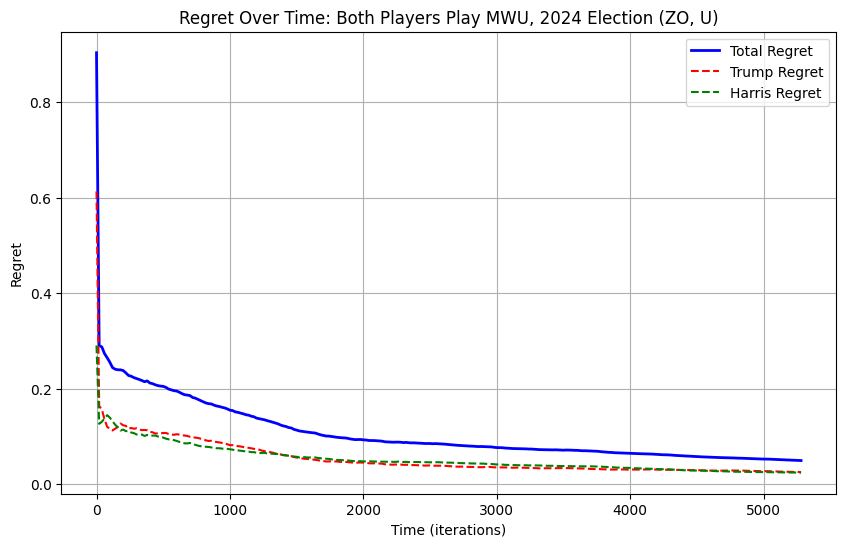

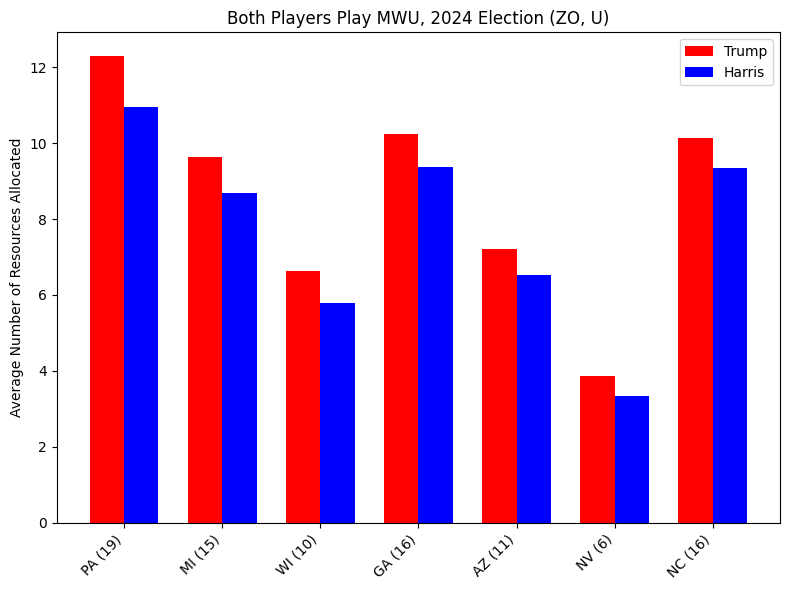

In [ ]:
#Both players play MWU, zero_one_uniform
T = 7000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (ZO, U)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="zero_one_uniform")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 4940
Final regret: 0.04995070868506729
Runtime: 71.33734226226807 seconds
Player 0 final strategy allocation at iteration 4940: [24  5 10  1  2  1 17]
Player 1 final strategy allocation at iteration 4940: [23  2 10  9  0  4  6]

Average Allocations (All Iterations):
Player 0 average allocation: [12.34939271  9.58360324  6.55647773 10.2888664   7.29696356  3.85688259
 10.07995951]
Player 1 average allocation: [11.06477733  8.8340081   5.75769231  9.2340081   6.41437247  3.32449393
  9.38157895]

Distribution of Allocations for Player 0:
[[0.01558704 0.02813765 0.03684211 0.04311741 0.04696356 0.04271255
  0.04453441 0.04271255 0.04190283 0.04554656 0.03825911 0.03765182
  0.03906883 0.04048583 0.04048583 0.04392713 0.03724696 0.04331984
  0.04331984 0.05445344 0.05546559 0.04615385 0.04210526 0.02267206
  0.01275304 0.00404858 0.00263158 0.00283401 0.00121457 0.00101215
  0.00080972 0.00020243 0.00

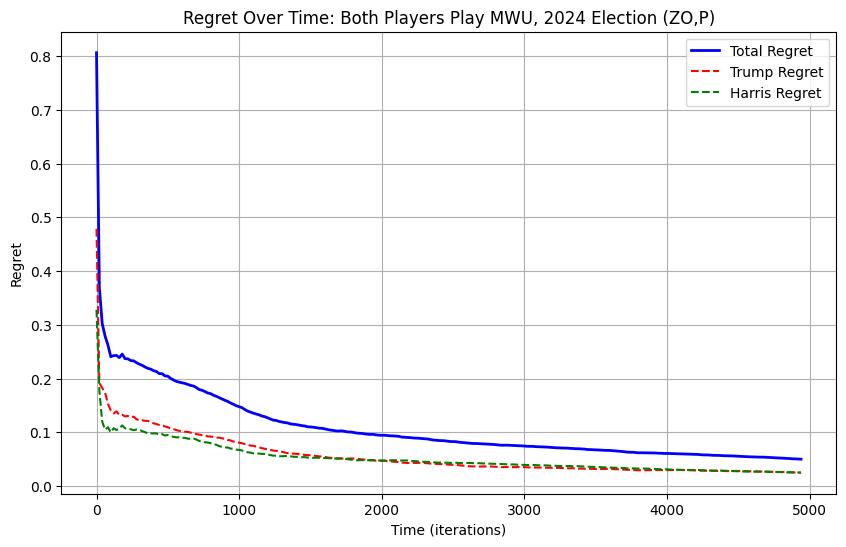

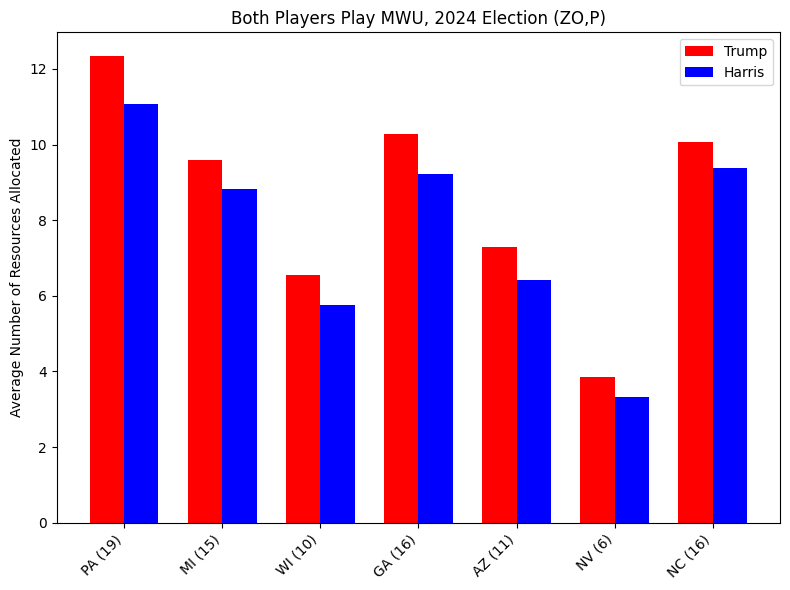

In [ ]:
#Both players play MWU, zero_one_proportional
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.proportional
init_factor = 0
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (ZO,P)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="zero_one_proportional")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5180
Final regret: 0.04969252832411519
Runtime: 73.35763454437256 seconds
Player 0 final strategy allocation at iteration 5180: [16  4  7  9 13  6  5]
Player 1 final strategy allocation at iteration 5180: [13 14  8  0  3  0 16]

Average Allocations (All Iterations):
Player 0 average allocation: [12.46081081  9.58474903  6.55772201 10.24498069  7.31525097  3.77683398
 10.07123552]
Player 1 average allocation: [11.03899614  8.63667954  5.77702703  9.31544402  6.57857143  3.40984556
  9.253861  ]

Distribution of Allocations for Player 0:
[[0.01640927 0.02760618 0.03590734 0.04247104 0.03899614 0.04169884
  0.04227799 0.04478764 0.04169884 0.03899614 0.03996139 0.04073359
  0.0484556  0.04054054 0.04092664 0.04247104 0.03918919 0.04227799
  0.04903475 0.04362934 0.05733591 0.05212355 0.04285714 0.02451737
  0.01312741 0.00617761 0.0019305  0.00057915 0.0007722  0.0007722
  0.0003861  0.00019305 0.   

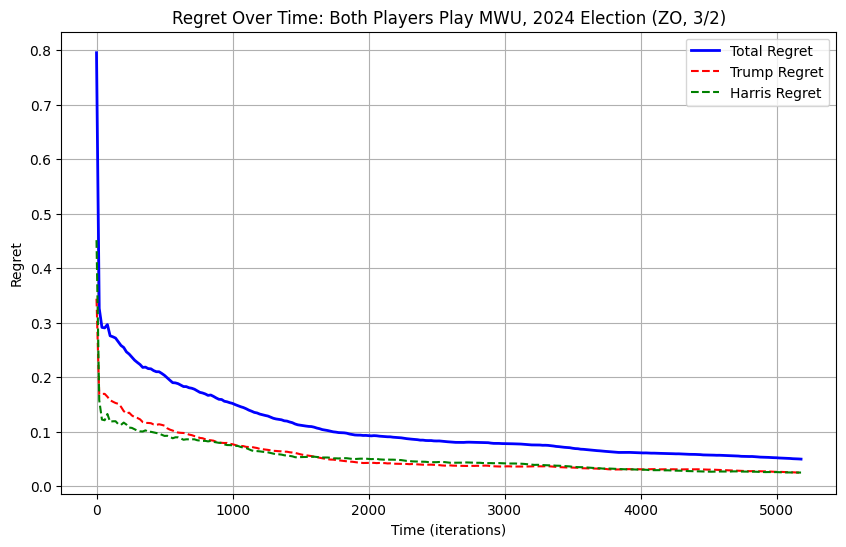

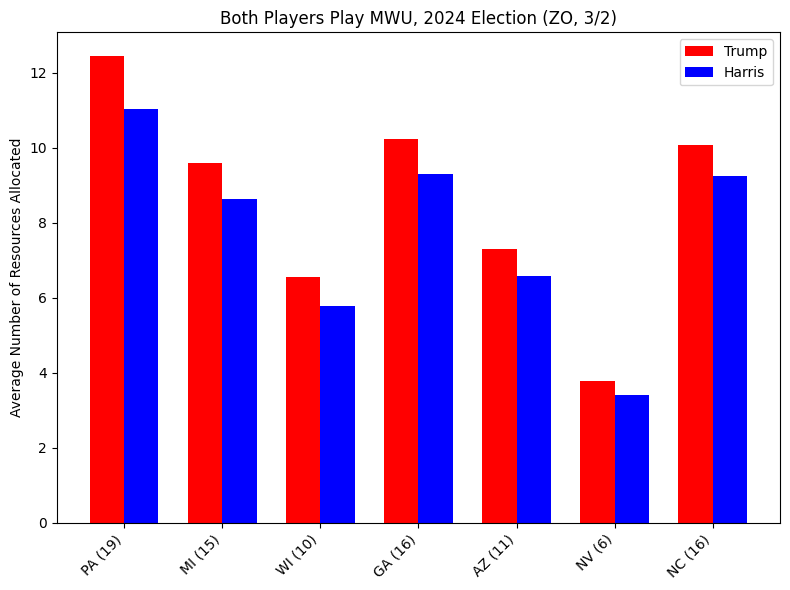

In [ ]:
#Both players play MWU, zero_one_three_halves
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.three_halves
init_factor = 0
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (ZO, 3/2)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="zero_one_three_halves")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

<ipython-input-3-a36cb37978e3>:406: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(denom==0,0.5, opp_mat/denom)


Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 6640
Final regret: 0.04998842216289745
Runtime: 92.35620927810669 seconds
Player 0 final strategy allocation at iteration 6640: [17  9  5  9  7  4  9]
Player 1 final strategy allocation at iteration 6640: [14  9  5 11  6  3  6]

Average Allocations (All Iterations):
Player 0 average allocation: [11.59096386  9.4253012   6.84036145 10.06957831  7.35512048  4.69277108
 10.03493976]
Player 1 average allocation: [10.48237952  8.59593373  6.02650602  9.10075301  6.67786145  4.14713855
  8.97756024]

Distribution of Allocations for Player 0:
[[2.71084337e-03 7.98192771e-03 8.13253012e-03 8.43373494e-03
  1.61144578e-02 2.37951807e-02 3.23795181e-02 4.65361446e-02
  6.44578313e-02 8.61445783e-02 9.56325301e-02 1.08885542e-01
  1.07228916e-01 9.53313253e-02 8.41867470e-02 6.05421687e-02
  4.72891566e-02 3.29819277e-02 1.89759036e-02 1.58132530e-02
  1.15963855e-02 7.53012048e-03 4.21686747e-03 4.21686747e

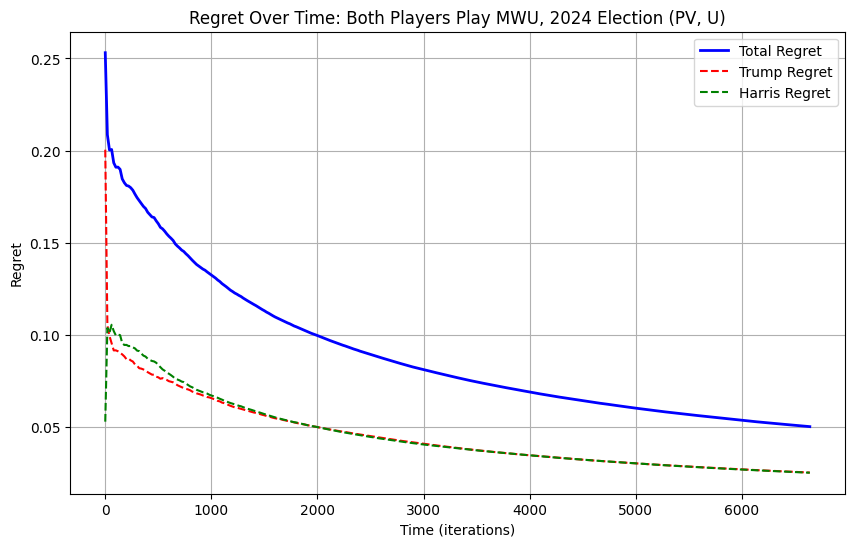

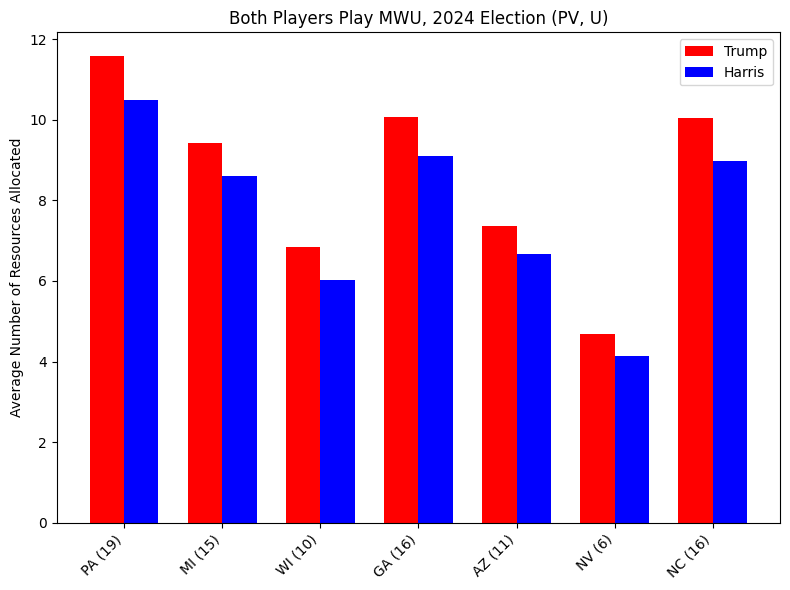

In [ ]:
#Both players play MWU, popular_vote_uniform
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.popular_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (PV, U)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="popular_vote_uniform")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

<ipython-input-3-a36cb37978e3>:406: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(denom==0,0.5, opp_mat/denom)


Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 6640
Final regret: 0.049998887110301315
Runtime: 91.92472648620605 seconds
Player 0 final strategy allocation at iteration 6640: [14  8  7 11  6  4 10]
Player 1 final strategy allocation at iteration 6640: [10  8  5 10  6  3 12]

Average Allocations (All Iterations):
Player 0 average allocation: [11.62650602  9.48207831  6.78599398 10.08177711  7.34503012  4.70948795
  9.97816265]
Player 1 average allocation: [10.50768072  8.5061747   6.12394578  9.03162651  6.53237952  4.19879518
  9.10753012]

Distribution of Allocations for Player 0:
[[3.16265060e-03 7.22891566e-03 8.88554217e-03 1.12951807e-02
  1.52108434e-02 2.27409639e-02 2.84638554e-02 4.53313253e-02
  6.00903614e-02 8.62951807e-02 1.03915663e-01 1.04668675e-01
  1.02710843e-01 1.04969880e-01 7.83132530e-02 6.20481928e-02
  5.04518072e-02 3.44879518e-02 2.03313253e-02 1.41566265e-02
  1.03915663e-02 6.02409639e-03 4.96987952e-03 4.06626506

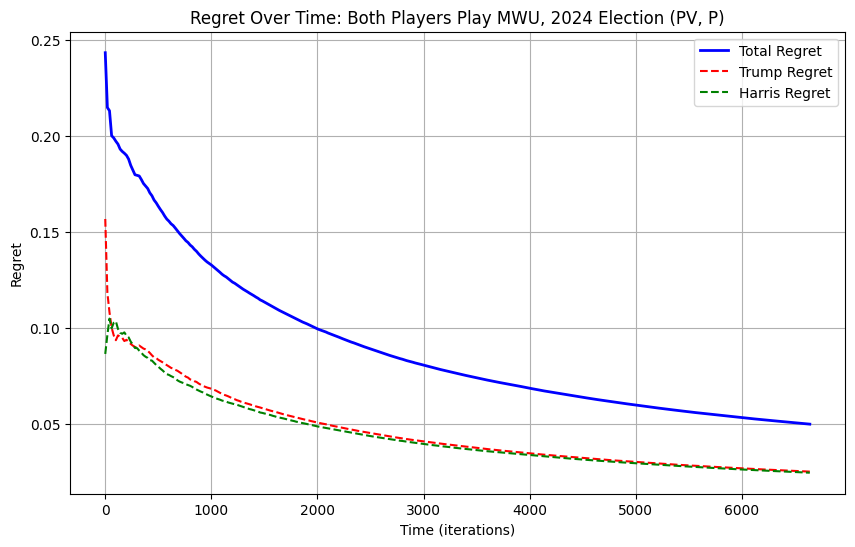

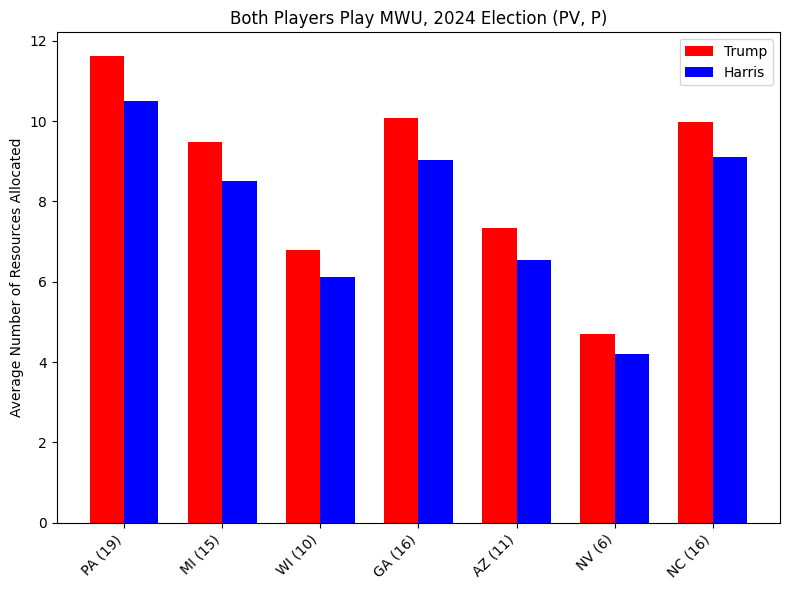

In [ ]:
#Both players play MWU, popular_vote_proportional
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.proportional
init_factor = 0
lt = LossType.popular_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (PV, P)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="popular_vote_proportional")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

<ipython-input-3-a36cb37978e3>:406: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(denom==0,0.5, opp_mat/denom)


Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 6700
Final regret: 0.04990696991374155
Runtime: 93.80134844779968 seconds
Player 0 final strategy allocation at iteration 6700: [ 8 14  7  8  5  3 15]
Player 1 final strategy allocation at iteration 6700: [13  9  3 11  4  5  9]

Average Allocations (All Iterations):
Player 0 average allocation: [11.71328358  9.45029851  6.85208955  9.96940299  7.27641791  4.64731343
 10.10014925]
Player 1 average allocation: [10.50970149  8.60164179  6.12432836  8.97044776  6.62835821  4.1719403
  9.00164179]

Distribution of Allocations for Player 0:
[[3.58208955e-03 4.92537313e-03 8.65671642e-03 1.25373134e-02
  1.41791045e-02 2.13432836e-02 3.13432836e-02 4.19402985e-02
  6.25373134e-02 7.95522388e-02 9.65671642e-02 1.14477612e-01
  1.15522388e-01 9.19402985e-02 8.01492537e-02 6.23880597e-02
  4.62686567e-02 3.19402985e-02 2.52238806e-02 1.61194030e-02
  1.14925373e-02 7.91044776e-03 6.26865672e-03 2.38805970e-

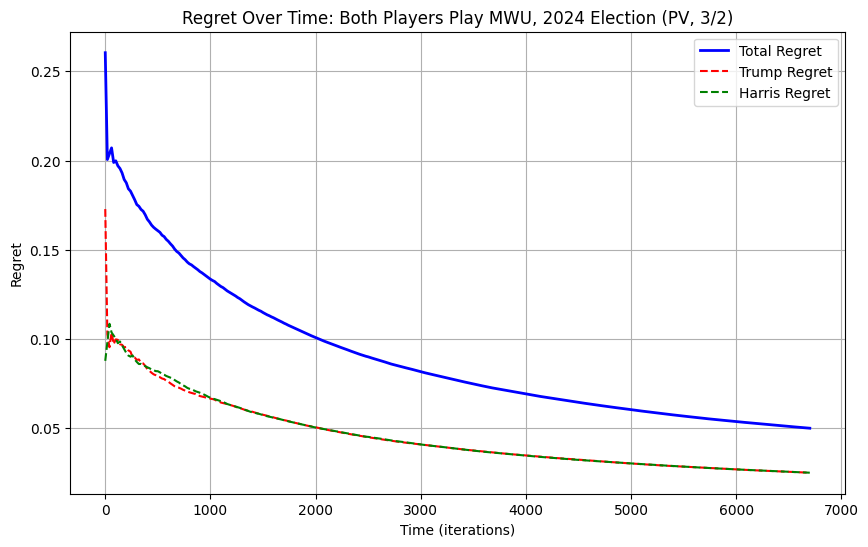

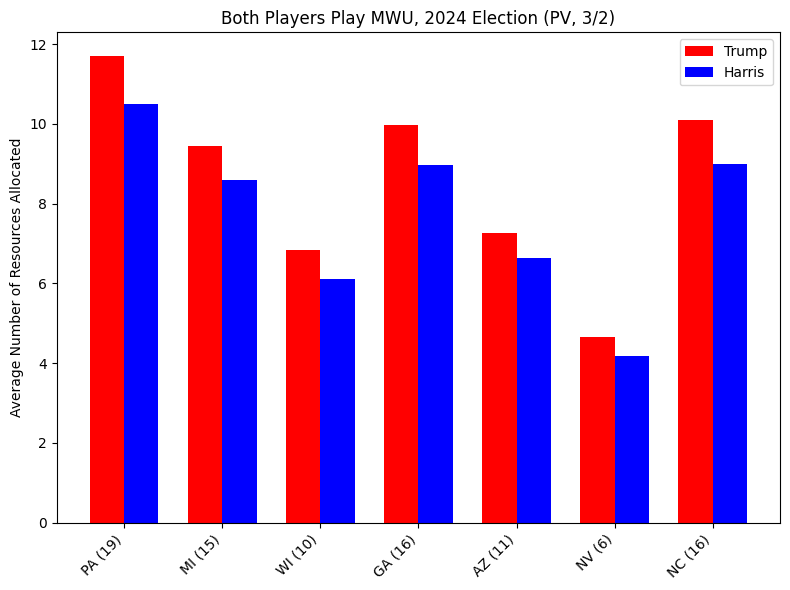

In [ ]:
#Both players play MWU, popular_vote_three_halves
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.three_halves
init_factor = 0
lt = LossType.popular_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (PV, 3/2)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="popular_vote_three_halves")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5960
Final regret: 0.049953432977836054
Runtime: 138.10258030891418 seconds
Player 0 final strategy allocation at iteration 5960: [ 7  2  6 16 10  3 16]
Player 1 final strategy allocation at iteration 5960: [19  6  0  6 11  5  7]

Average Allocations (All Iterations):
Player 0 average allocation: [12.63540268  9.47466443  6.68087248  9.96510067  7.38758389  3.77281879
 10.09362416]
Player 1 average allocation: [11.02919463  8.73909396  5.83909396  9.26073826  6.54714765  3.31308725
  9.2807047 ]

Distribution of Allocations for Player 0:
[[1.42617450e-02 2.50000000e-02 3.70805369e-02 3.77516779e-02
  4.78187919e-02 3.82550336e-02 4.27852349e-02 4.09395973e-02
  4.06040268e-02 3.84228188e-02 3.59060403e-02 3.80872483e-02
  3.32214765e-02 3.35570470e-02 3.37248322e-02 3.64093960e-02
  4.83221477e-02 6.02348993e-02 6.34228188e-02 7.29865772e-02
  6.67785235e-02 5.21812081e-02 3.13758389e-02 1.6107382

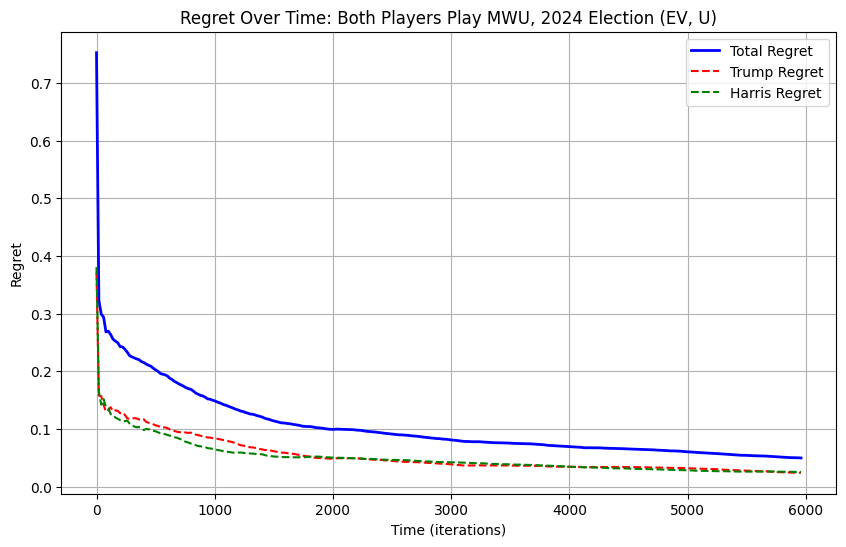

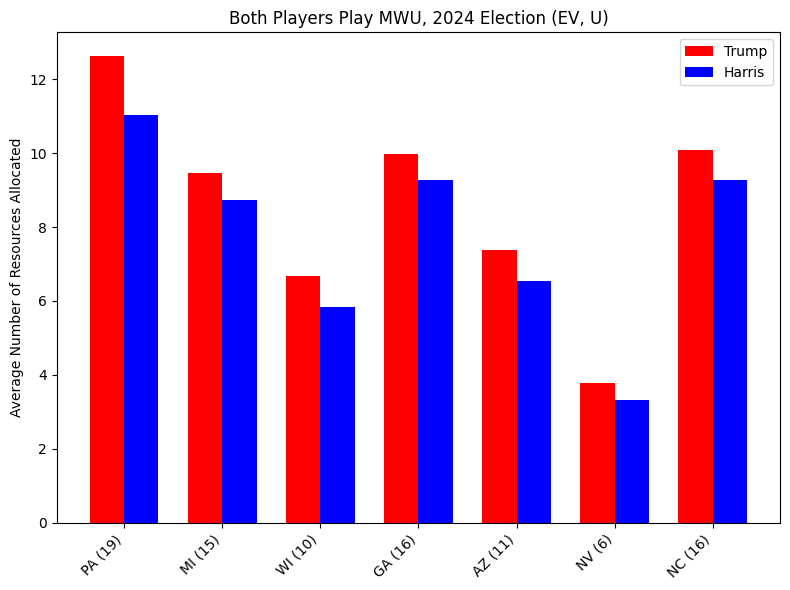

In [ ]:
#Both players play MWU, electoral_vote_uniform
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (EV, U)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="electoral_vote_uniform")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5780
Final regret: 0.049971818090522646
Runtime: 151.44361543655396 seconds
Player 0 final strategy allocation at iteration 5780: [22  1  2 16 12  5  2]
Player 1 final strategy allocation at iteration 5780: [ 0  7  8  7 12  3 17]

Average Allocations (All Iterations):
Player 0 average allocation: [12.41799308  9.36989619  6.67785467 10.20709343  7.33979239  3.74619377
 10.25155709]
Player 1 average allocation: [10.94048443  8.72474048  5.91487889  9.22923875  6.56297578  3.34792388
  9.28910035]

Distribution of Allocations for Player 0:
[[1.29757785e-02 2.73356401e-02 3.66782007e-02 3.73702422e-02
  5.08650519e-02 4.84429066e-02 4.27335640e-02 3.77162630e-02
  4.13494810e-02 3.96193772e-02 3.96193772e-02 3.63321799e-02
  3.51211073e-02 3.23529412e-02 3.54671280e-02 4.01384083e-02
  4.37716263e-02 5.81314879e-02 6.15916955e-02 7.68166090e-02
  6.05536332e-02 4.80968858e-02 2.57785467e-02 1.2283737

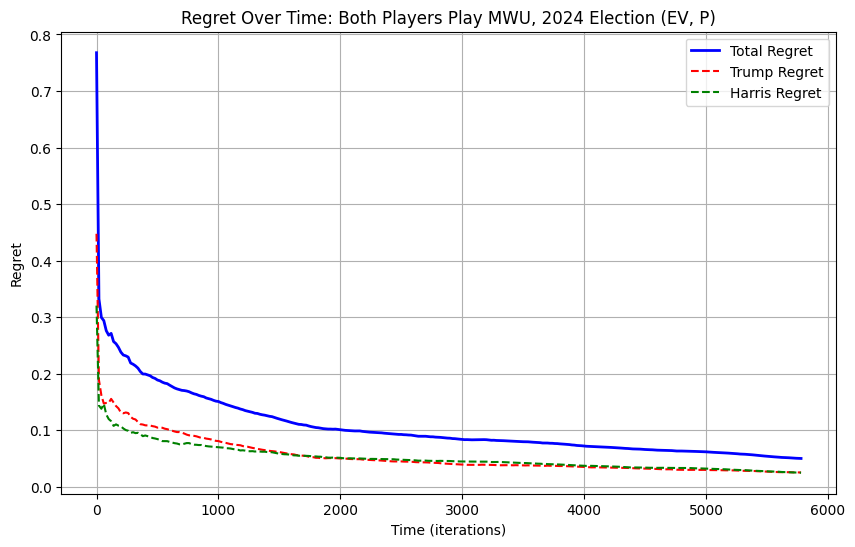

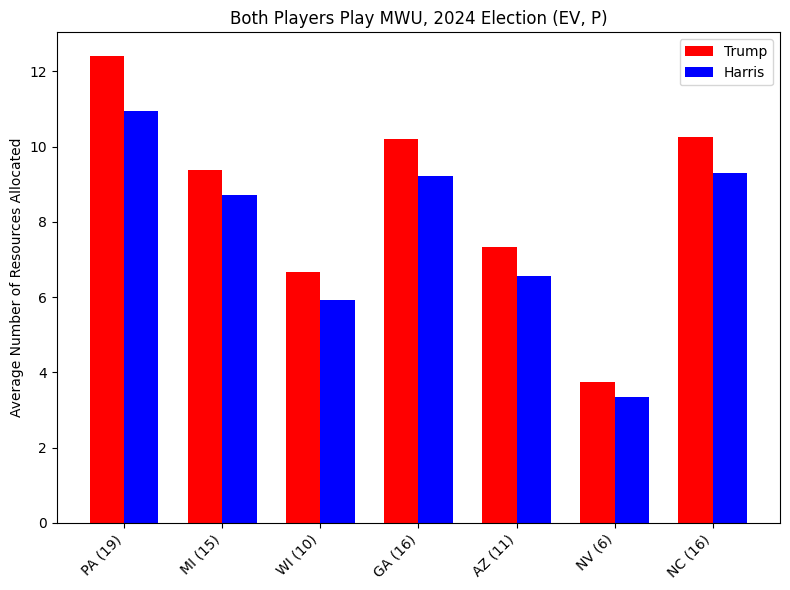

In [ ]:
#Both players play MWU, electoral_vote_proportional
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.proportional
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (EV, P)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="electoral_vote_proportional")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5800
Final regret: 0.049955701252719475
Runtime: 148.26999878883362 seconds
Player 0 final strategy allocation at iteration 5800: [17 16  4  8  9  4  2]
Player 1 final strategy allocation at iteration 5800: [ 8 14  0 15 10  0  7]

Average Allocations (All Iterations):
Player 0 average allocation: [12.2987931   9.575       6.60672414 10.04224138  7.47224138  3.76413793
 10.2512069 ]
Player 1 average allocation: [10.86896552  8.75724138  5.85068966  9.40327586  6.49103448  3.36948276
  9.26862069]

Distribution of Allocations for Player 0:
[[1.43103448e-02 2.67241379e-02 3.29310345e-02 4.50000000e-02
  4.60344828e-02 4.74137931e-02 4.86206897e-02 4.68965517e-02
  4.37931034e-02 3.50000000e-02 3.39655172e-02 3.68965517e-02
  3.08620690e-02 3.43103448e-02 3.63793103e-02 4.00000000e-02
  4.51724138e-02 5.63793103e-02 7.27586207e-02 6.55172414e-02
  6.13793103e-02 4.41379310e-02 2.46551724e-02 1.5862069

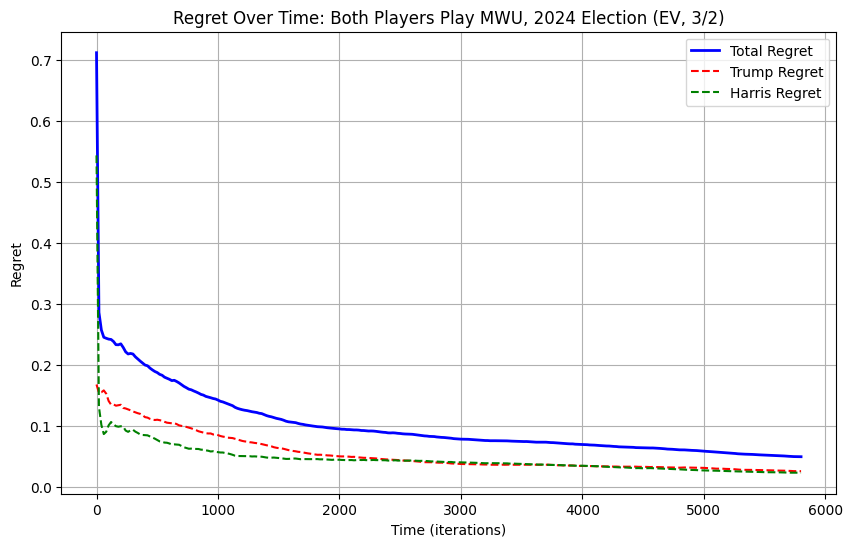

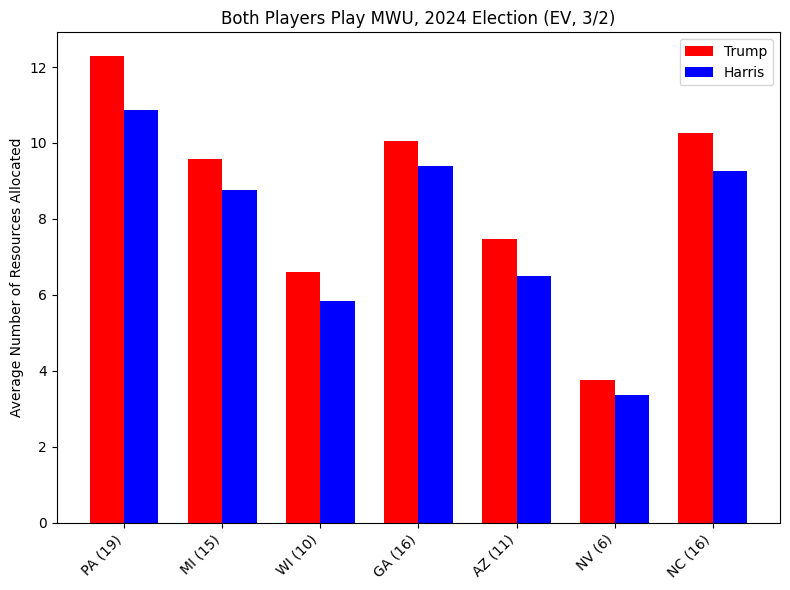

In [ ]:
#Both players play MWU, electoral_vote_three_halves
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.three_halves
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (EV, 3/2)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="electoral_vote_three_halves")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5600
Final regret: 0.049658532763170726
Runtime: 143.29379534721375 seconds
Player 0 final strategy allocation at iteration 5600: [10  4  7  2 14  5 18]
Player 1 final strategy allocation at iteration 5600: [15 17 11  7  0  2  2]

Average Allocations (All Iterations):
Player 0 average allocation: [12.40875     9.56196429  6.54875    10.24910714  7.28        3.77553571
 10.18660714]
Player 1 average allocation: [10.91928571  8.77196429  5.80535714  9.36053571  6.53267857  3.39767857
  9.22214286]

Distribution of Allocations for Player 0:
[[0.01339286 0.02696429 0.04       0.04517857 0.03964286 0.04571429
  0.04017857 0.04392857 0.04696429 0.03767857 0.03535714 0.03482143
  0.03392857 0.03267857 0.03625    0.04196429 0.04678571 0.0525
  0.06232143 0.0725     0.06464286 0.04767857 0.02839286 0.01553571
  0.00625    0.00232143 0.00214286 0.00196429 0.00089286 0.00053571
  0.00035714 0.         0.0003

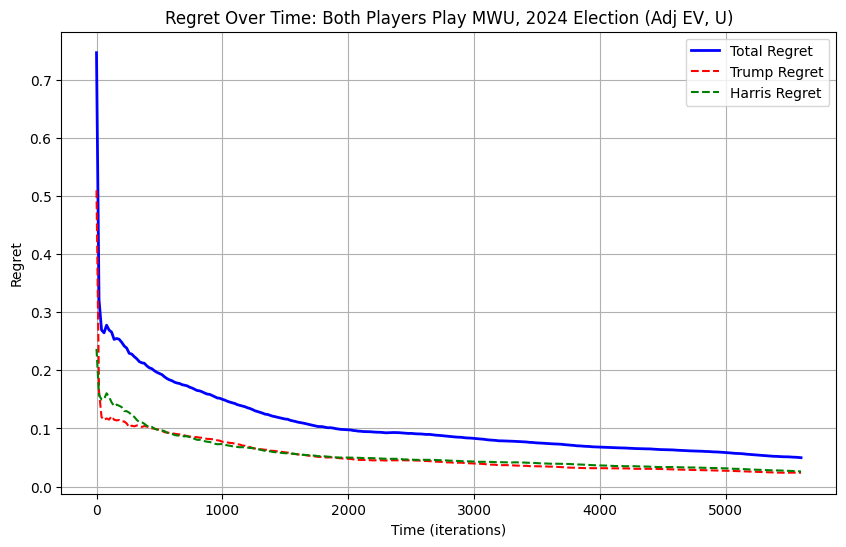

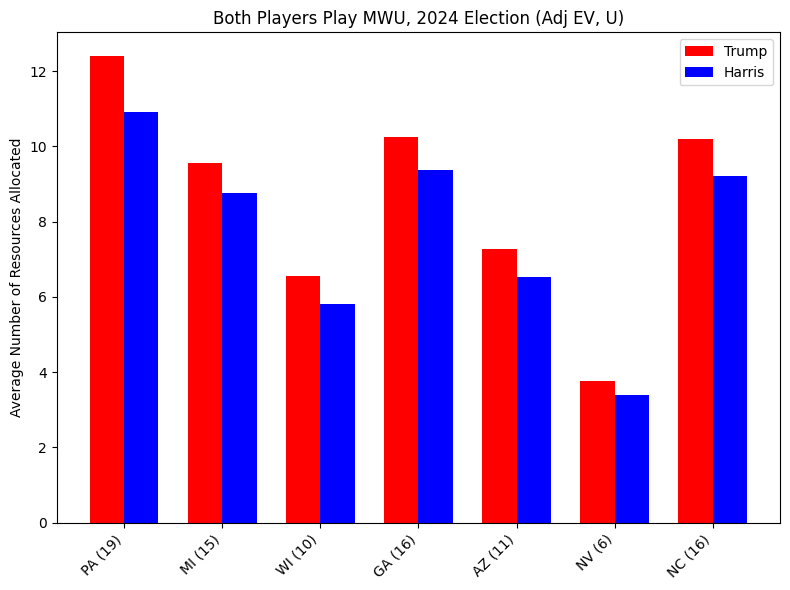

In [ ]:
#Both players play MWU, adj_electoral_vote_uniform
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.ev_adj
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (Adj EV, U)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="adj_electoral_vote_uniform")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5620
Final regret: 0.049823804032093855
Runtime: 144.81241869926453 seconds
Player 0 final strategy allocation at iteration 5620: [19  1  7  6  4  5 18]
Player 1 final strategy allocation at iteration 5620: [12 16  1  5  0  5 15]

Average Allocations (All Iterations):
Player 0 average allocation: [12.37935943  9.4544484   6.62882562 10.16797153  7.3069395   3.78451957
 10.2886121 ]
Player 1 average allocation: [10.98185053  8.66049822  5.84839858  9.48967972  6.48362989  3.30302491
  9.24252669]

Distribution of Allocations for Player 0:
[[0.0133452  0.02775801 0.0411032  0.0480427  0.04377224 0.04483986
  0.04217082 0.04252669 0.0366548  0.03701068 0.04145907 0.03380783
  0.03576512 0.03540925 0.03327402 0.03594306 0.04395018 0.05462633
  0.06476868 0.0658363  0.06085409 0.0544484  0.0297153  0.01565836
  0.00747331 0.00320285 0.00284698 0.00213523 0.00035587 0.00035587
  0.00053381 0.00017794 0.

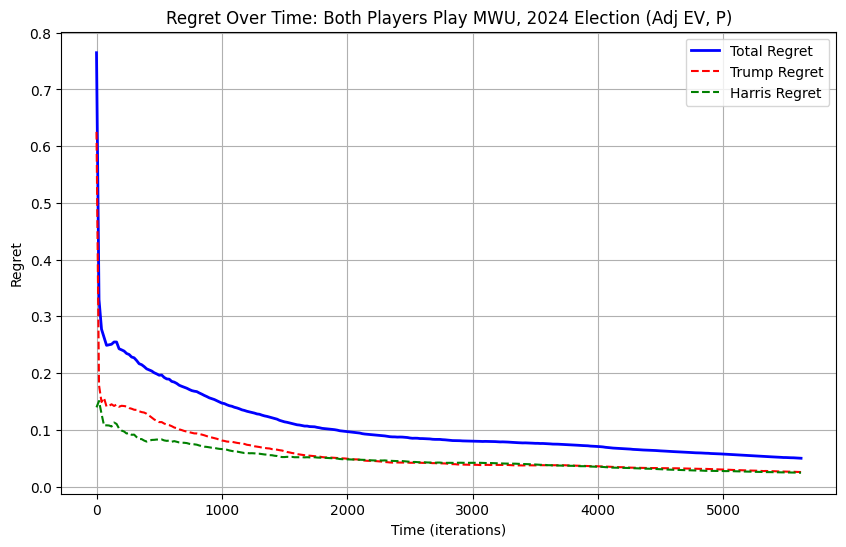

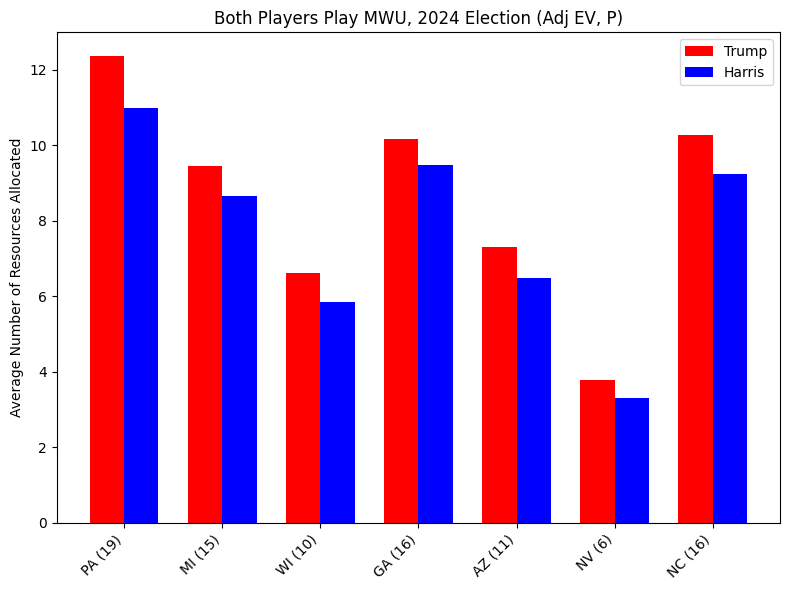

In [ ]:
#Both players play MWU, adj_electoral_vote_proportional
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.proportional
init_factor = 0
lt = LossType.ev_adj
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (Adj EV, P)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="adj_electoral_vote_proportional")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5840
Final regret: 0.049948854712103974
Runtime: 158.31740188598633 seconds
Player 0 final strategy allocation at iteration 5840: [20 15  1 15  2  4  3]
Player 1 final strategy allocation at iteration 5840: [ 4 17  4  0 10  3 16]

Average Allocations (All Iterations):
Player 0 average allocation: [12.54469178  9.49452055  6.58424658 10.2005137   7.30856164  3.79023973
 10.0875    ]
Player 1 average allocation: [10.86695205  8.69691781  5.94691781  9.28972603  6.60582192  3.38458904
  9.21832192]

Distribution of Allocations for Player 0:
[[1.19863014e-02 2.53424658e-02 3.98972603e-02 4.21232877e-02
  4.45205479e-02 4.50342466e-02 4.38356164e-02 4.04109589e-02
  4.16095890e-02 3.54452055e-02 3.59589041e-02 3.54452055e-02
  3.40753425e-02 3.30479452e-02 3.44178082e-02 3.90410959e-02
  4.91438356e-02 5.39383562e-02 6.23287671e-02 6.84931507e-02
  6.96917808e-02 5.66780822e-02 2.99657534e-02 1.2842465

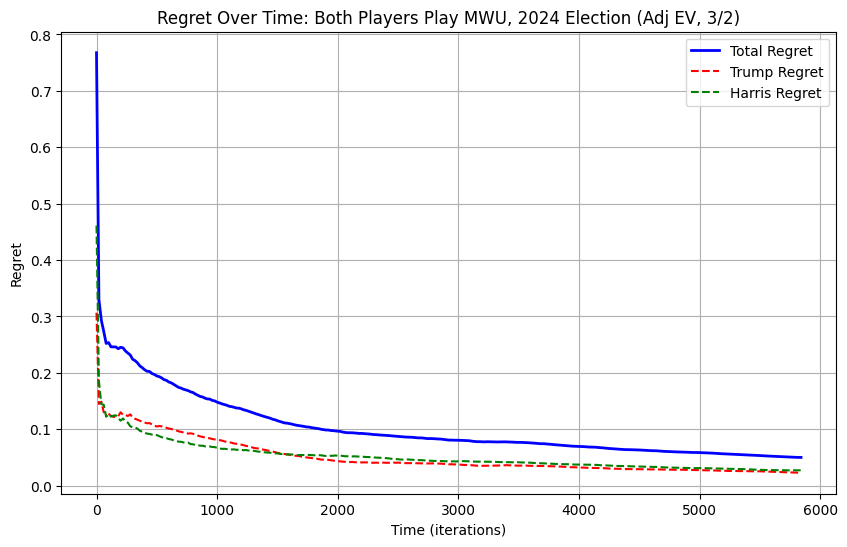

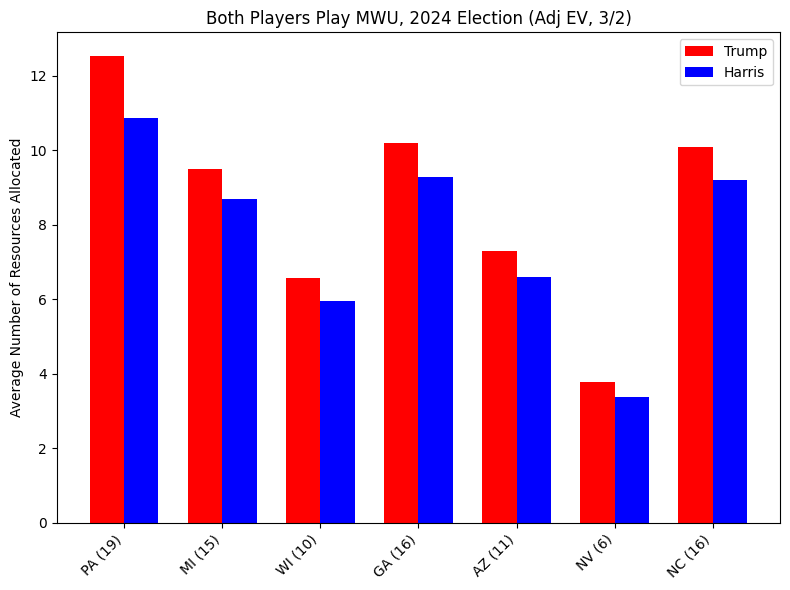

In [ ]:
#Both players play MWU, adj_electoral_vote_three_halves
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.three_halves
init_factor = 0
lt = LossType.ev_adj
calc_d2e = False
fixed_strategy = np.array([])
ev_adv =  [0.0]*k
title = "Both Players Play MWU, 2024 Election (Adj EV, 3/2)"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="adj_electoral_vote_three_halves")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

# Fixed Strategy & MWU Allocations

Battles: 7
Soldiers: [54 60]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 1000
Final regret: 0.42864862334785114
Runtime: 18.792025089263916 seconds
Player 0 final strategy allocation at iteration 1000: [16 10  8  6  4  4  6]
Player 1 final strategy allocation at iteration 1000: [21 12  0  8  6  5  8]

Average Allocations (All Iterations):
Player 0 average allocation: [16.016 10.01   8.008  6.006  4.004  4.004  6.006]
Player 1 average allocation: [10.457 10.616  7.322  9.236  7.317  5.592  9.52 ]

Distribution of Allocations for Player 0:
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    1.001 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.001 0.
  0.    0.    0.    0.    0.    0.    0

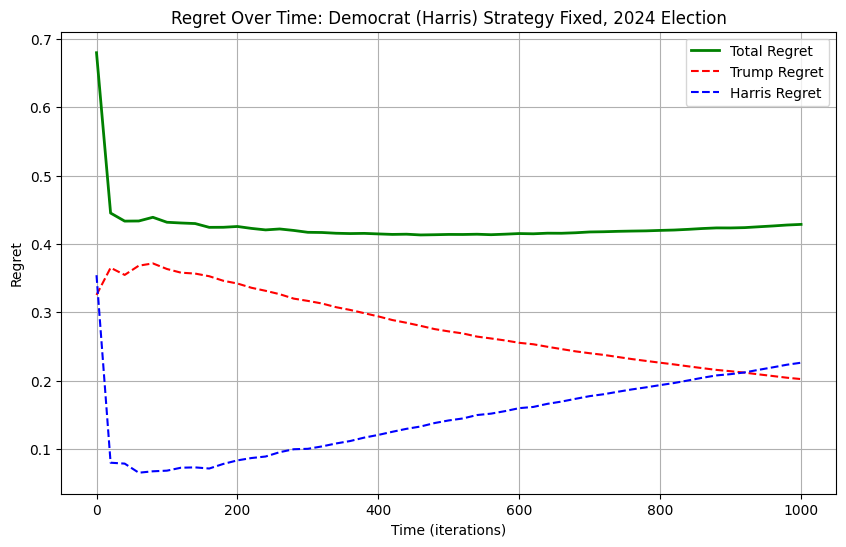

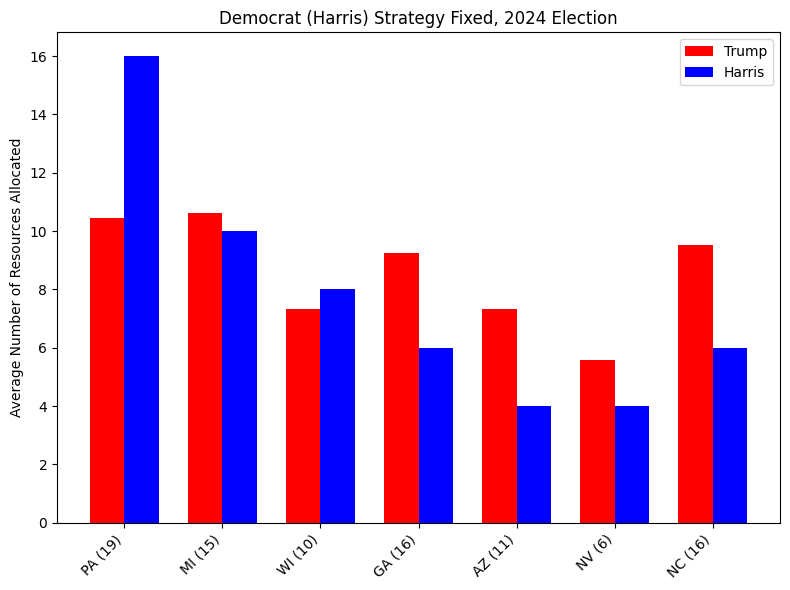

In [23]:
#Democrat (Harris) Strategy Fixed
T = 1000
L = 2
k = 7
N = [54, 60]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_harris)
ev_adv =  [0.0]*k
title = "Democrat (Harris) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_vote_uniform")
plot_regret(game, swap_players=True, title = title)
plot_avg_strat(game,swing_states,swap_players=True, title = title)

Battles: 7
Soldiers: [54 60]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 2000
Final regret: 0.4694635656316023
Runtime: 36.938719511032104 seconds
Player 0 final strategy allocation at iteration 2000: [16 10  8  6  4  4  6]
Player 1 final strategy allocation at iteration 2000: [19 14  0  9  7  2  9]

Average Allocations (All Iterations):
Player 0 average allocation: [16.008 10.005  8.004  6.003  4.002  4.002  6.003]
Player 1 average allocation: [12.9955 11.465   5.7315  9.0685  6.758   5.0215  8.99  ]

Distribution of Allocations for Player 0:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     1.0005 0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.  

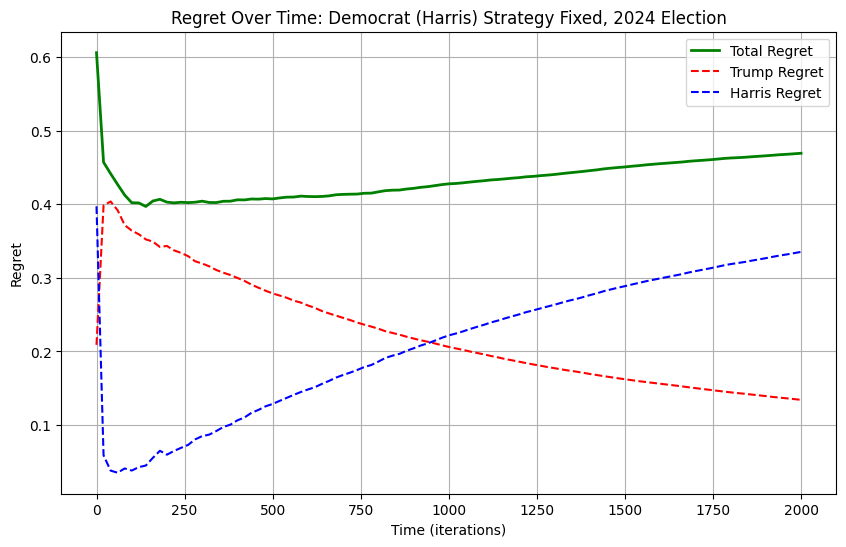

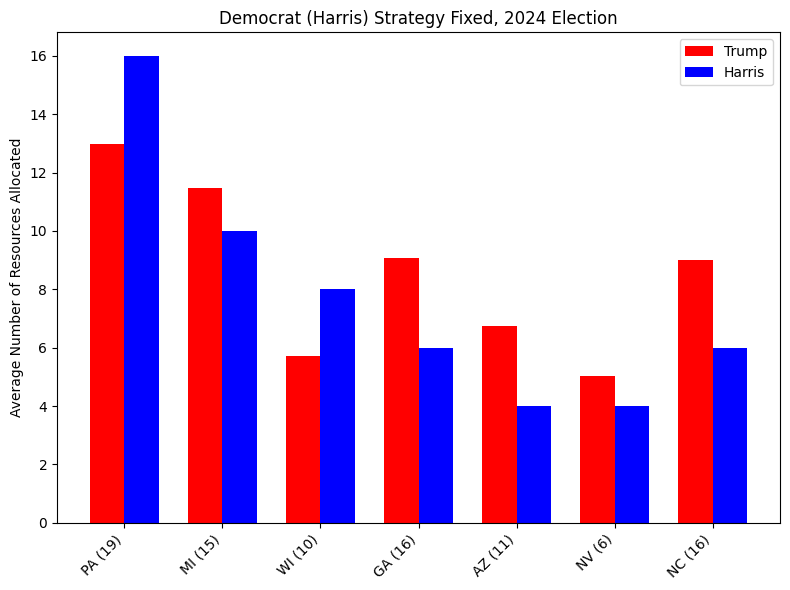

In [24]:
#Democrat (Harris) Strategy Fixed
T = 2000
L = 2
k = 7
N = [54, 60]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_harris)
ev_adv =  [0.0]*k
title = "Democrat (Harris) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_vote_uniform")
plot_regret(game, swap_players=True, title = title)
plot_avg_strat(game,swing_states,swap_players=True, title = title)

Battles: 7
Soldiers: [54 60]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5000
Final regret: 0.5204736804747416
Runtime: 89.8378233909607 seconds
Player 0 final strategy allocation at iteration 5000: [16 10  8  6  4  4  6]
Player 1 final strategy allocation at iteration 5000: [21 12  0  8  6  5  8]

Average Allocations (All Iterations):
Player 0 average allocation: [16.0032 10.002   8.0016  6.0012  4.0008  4.0008  6.0012]
Player 1 average allocation: [16.8788 12.1354  2.6474  8.5904  6.1566  5.0392  8.5642]

Distribution of Allocations for Player 0:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     1.0002 0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    

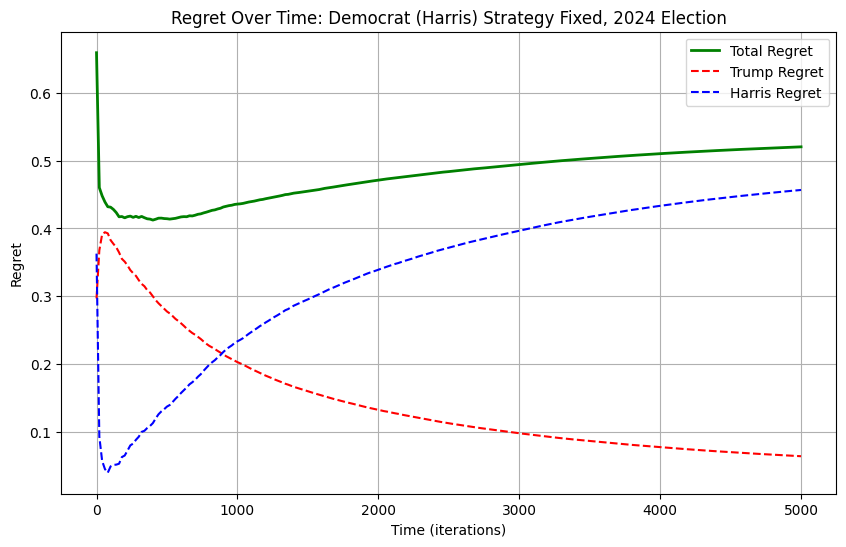

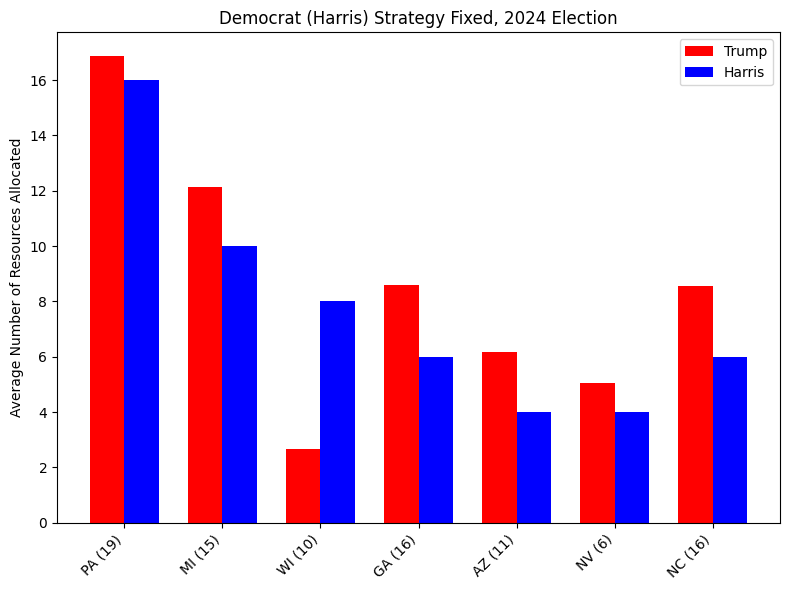

In [25]:
#Democrat (Harris) Strategy Fixed
T = 5000
L = 2
k = 7
N = [54, 60]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_harris)
ev_adv =  [0.0]*k
title = "Democrat (Harris) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_vote_uniform")
plot_regret(game, swap_players=True, title = title)
plot_avg_strat(game,swing_states,swap_players=True, title = title)

Battles: 7
Soldiers: [54 60]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 10000
Final regret: 0.55584131861718
Runtime: 176.16201090812683 seconds
Player 0 final strategy allocation at iteration 10000: [16 10  8  6  4  4  6]
Player 1 final strategy allocation at iteration 10000: [20 14  0  8  5  5  8]

Average Allocations (All Iterations):
Player 0 average allocation: [16.0016 10.001   8.0008  6.0006  4.0004  4.0004  6.0006]
Player 1 average allocation: [18.3116 12.4969  1.3687  8.3576  5.946   5.1773  8.3479]

Distribution of Allocations for Player 0:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     1.0001 0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0. 

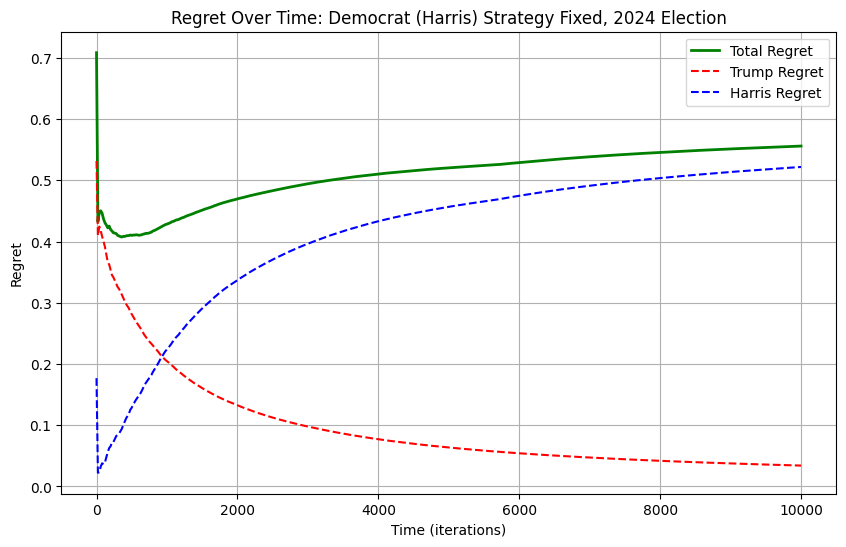

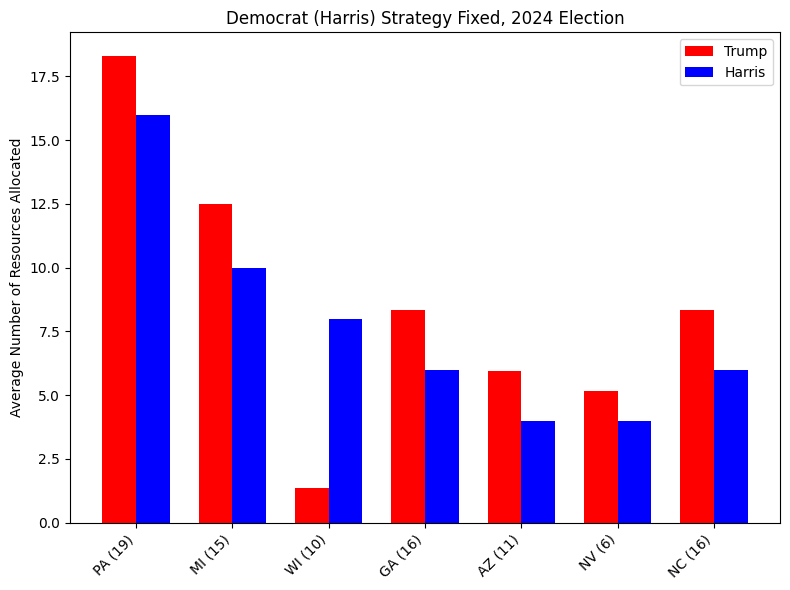

In [26]:
#Democrat (Harris) Strategy Fixed
T = 10000
L = 2
k = 7
N = [54, 60]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_harris)
ev_adv =  [0.0]*k
title = "Democrat (Harris) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_vote_uniform")
plot_regret(game, swap_players=True, title = title)
plot_avg_strat(game,swing_states,swap_players=True, title = title)

Battles: 7
Soldiers: [54 60]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 20000
Final regret: 0.577400584514391
Runtime: 356.8632662296295 seconds
Player 0 final strategy allocation at iteration 20000: [16 10  8  6  4  4  6]
Player 1 final strategy allocation at iteration 20000: [20 13  0  8  6  5  8]

Average Allocations (All Iterations):
Player 0 average allocation: [16.0008 10.0005  8.0004  6.0003  4.0002  4.0002  6.0003]
Player 1 average allocation: [19.10525 12.7391   0.67975  8.16205  5.9446   5.17065  8.2016 ]

Distribution of Allocations for Player 0:
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      1.00005 0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.

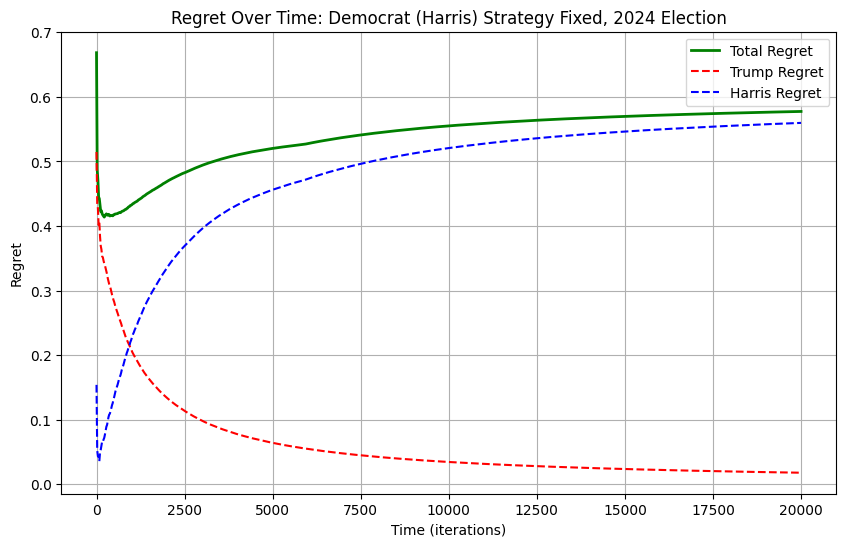

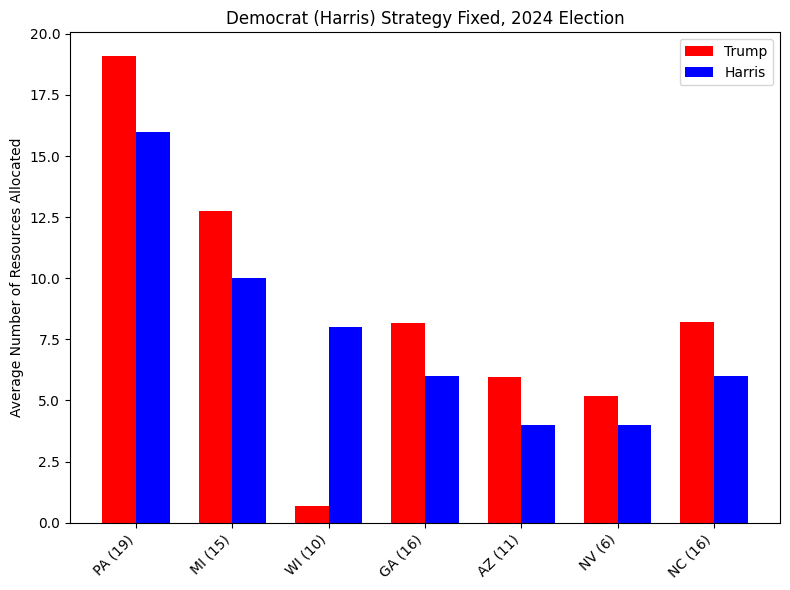

In [15]:
#Democrat (Harris) Strategy Fixed
T = 20000
L = 2
k = 7
N = [54, 60]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_harris)
ev_adv =  [0.0]*k
title = "Democrat (Harris) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_vote_uniform")
plot_regret(game, swap_players=True, title = title)
plot_avg_strat(game,swing_states,swap_players=True, title = title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 1000
Final regret: 0.3539904109854968
Runtime: 18.513789892196655 seconds
Player 0 final strategy allocation at iteration 1000: [15 11  7  7  4  5 11]
Player 1 final strategy allocation at iteration 1000: [ 1 13 10  8  5  2 15]

Average Allocations (All Iterations):
Player 0 average allocation: [15.015 11.011  7.007  7.007  4.004  5.005 11.011]
Player 1 average allocation: [8.247 8.561 6.684 9.267 6.589 4.977 9.729]

Distribution of Allocations for Player 0:
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    1.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.001
  0.    0

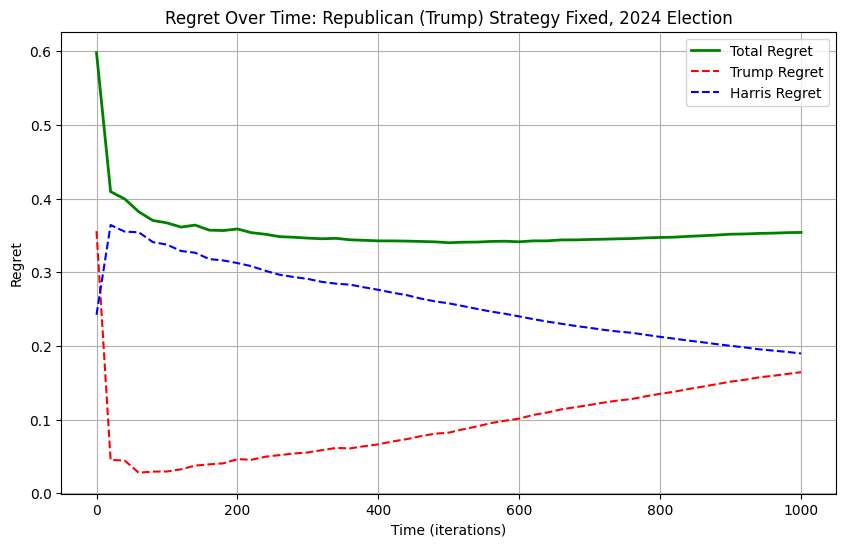

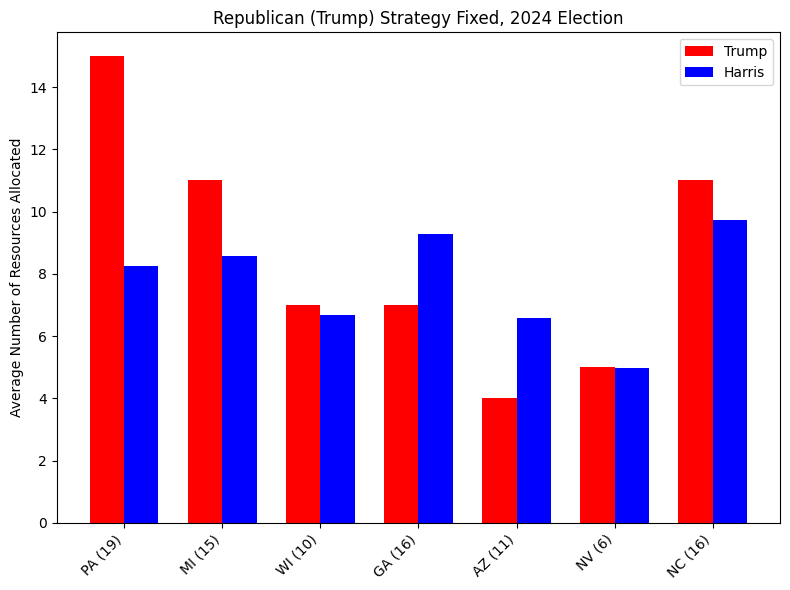

In [19]:
#Republican (Trump) Strategy Fixed
T = 1000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_trump)
ev_adv =  [0.0]*k
title = "Republican (Trump) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_votes_uniform")
plot_regret(game, title = title)
plot_avg_strat(game,swing_states,swap_players=False, title = title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 2000
Final regret: 0.38841979799339843
Runtime: 40.40741157531738 seconds
Player 0 final strategy allocation at iteration 2000: [15 11  7  7  4  5 11]
Player 1 final strategy allocation at iteration 2000: [ 1 14  9  9  6  0 15]

Average Allocations (All Iterations):
Player 0 average allocation: [15.0075 11.0055  7.0035  7.0035  4.002   5.0025 11.0055]
Player 1 average allocation: [ 7.233   9.47    6.5985  9.565   6.3535  3.8865 10.9205]

Distribution of Allocations for Player 0:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     1.0005 0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.    

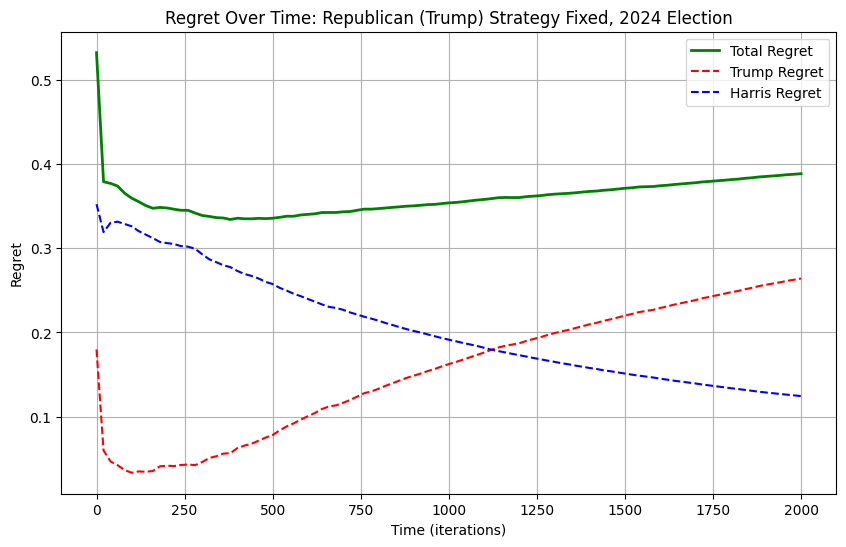

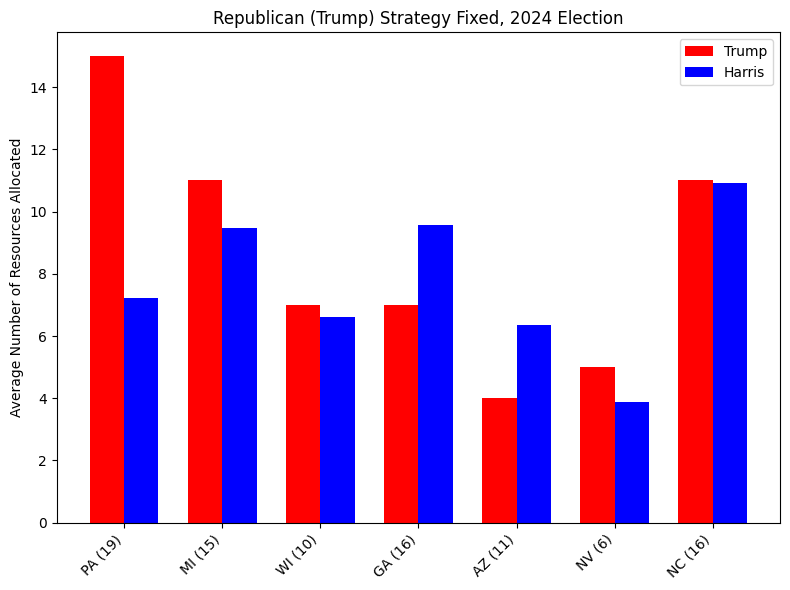

In [20]:
#Republican (Trump) Strategy Fixed
T = 2000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_trump)
ev_adv =  [0.0]*k
title = "Republican (Trump) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_votes_uniform")
plot_regret(game, title = title)
plot_avg_strat(game,swing_states,swap_players=False, title = title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 5000
Final regret: 0.45785846190044843
Runtime: 87.2527666091919 seconds
Player 0 final strategy allocation at iteration 5000: [15 11  7  7  4  5 11]
Player 1 final strategy allocation at iteration 5000: [ 0 15 10  9  6  0 14]

Average Allocations (All Iterations):
Player 0 average allocation: [15.003  11.0022  7.0014  7.0014  4.0008  5.001  11.0022]
Player 1 average allocation: [ 4.0782 11.7266  7.8492  9.564   6.1214  1.9692 12.7022]

Distribution of Allocations for Player 0:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     1.0002 0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     

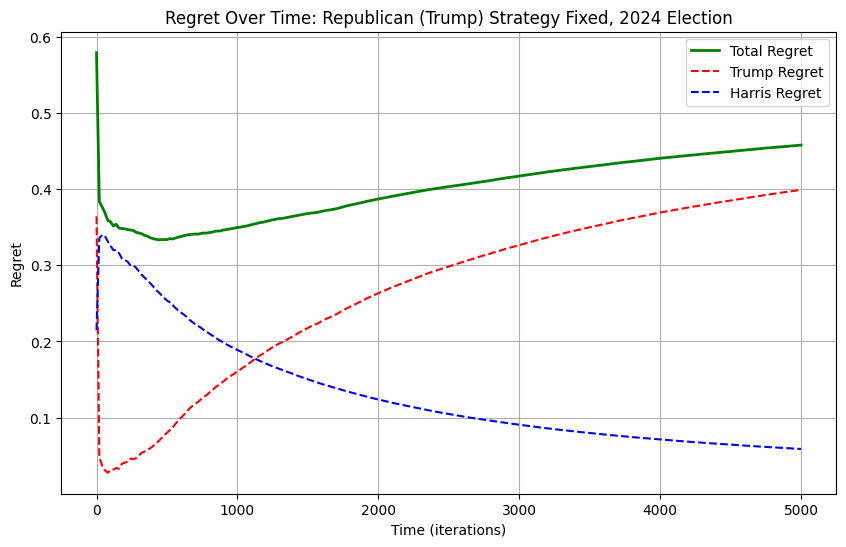

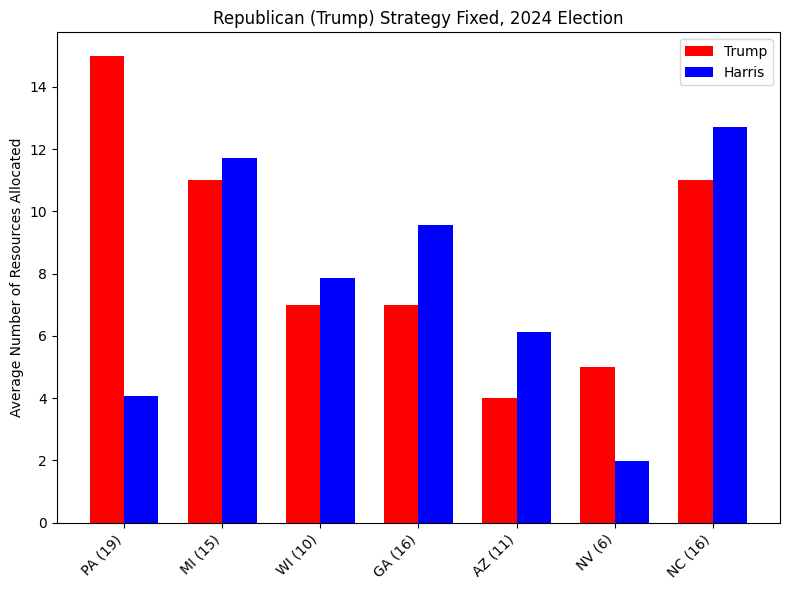

In [21]:
#Republican (Trump) Strategy Fixed
T = 5000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_trump)
ev_adv =  [0.0]*k
title = "Republican (Trump) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_votes_uniform")
plot_regret(game, title = title)
plot_avg_strat(game,swing_states,swap_players=False, title = title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 10000
Final regret: 0.5006173375577447
Runtime: 181.88338470458984 seconds
Player 0 final strategy allocation at iteration 10000: [15 11  7  7  4  5 11]
Player 1 final strategy allocation at iteration 10000: [ 0 16  9  9  6  0 14]

Average Allocations (All Iterations):
Player 0 average allocation: [15.0015 11.0011  7.0007  7.0007  4.0004  5.0005 11.0011]
Player 1 average allocation: [ 2.2354 12.9436  8.6633  9.5765  6.0086  0.9883 13.5897]

Distribution of Allocations for Player 0:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     1.0001 0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0. 

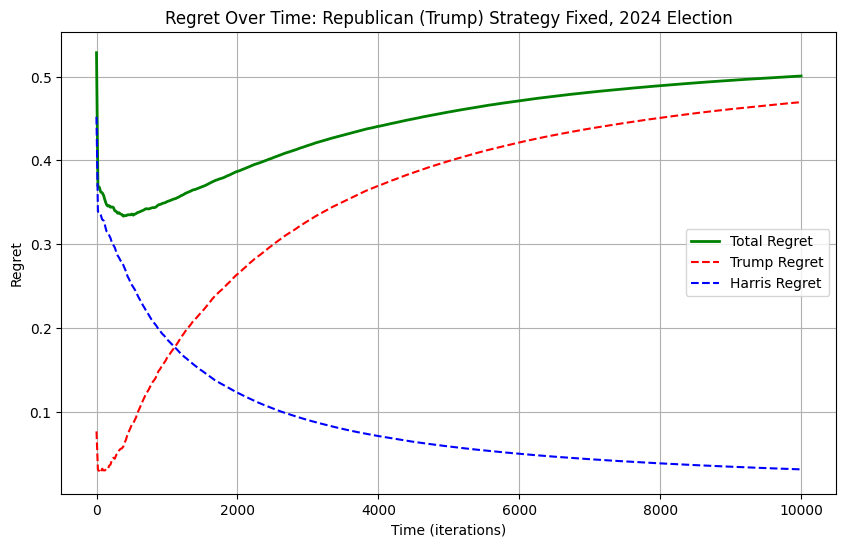

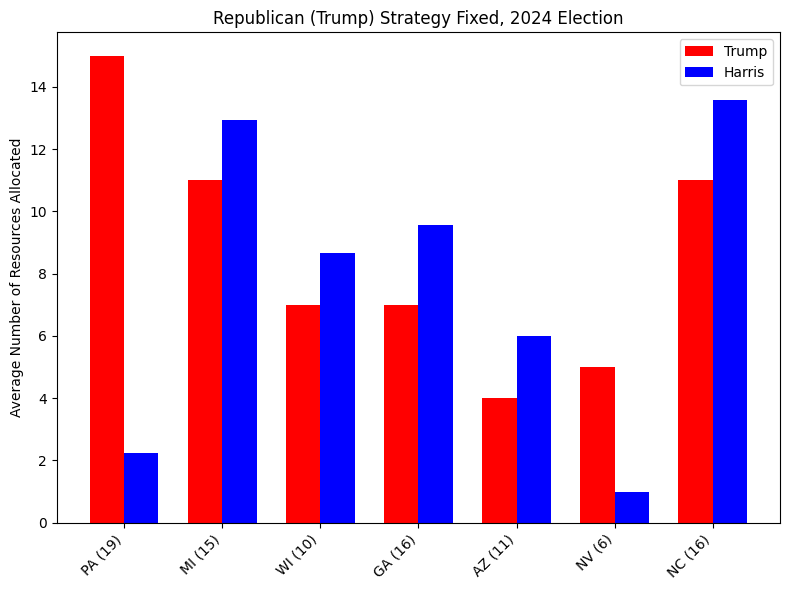

In [22]:
#Republican (Trump) Strategy Fixed
T = 10000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_trump)
ev_adv =  [0.0]*k
title = "Republican (Trump) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_votes_uniform")
plot_regret(game, title = title)
plot_avg_strat(game,swing_states,swap_players=False, title = title)

Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 20000
Final regret: 0.5257685558014495
Runtime: 342.6096167564392 seconds
Player 0 final strategy allocation at iteration 20000: [15 11  7  7  4  5 11]
Player 1 final strategy allocation at iteration 20000: [ 0 15  9 10  6  0 14]

Average Allocations (All Iterations):
Player 0 average allocation: [15.00075 11.00055  7.00035  7.00035  4.0002   5.00025 11.00055]
Player 1 average allocation: [ 1.0671  13.684    9.1277   9.6023   6.01615  0.47845 14.027  ]

Distribution of Allocations for Player 0:
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      1.00005 0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.     

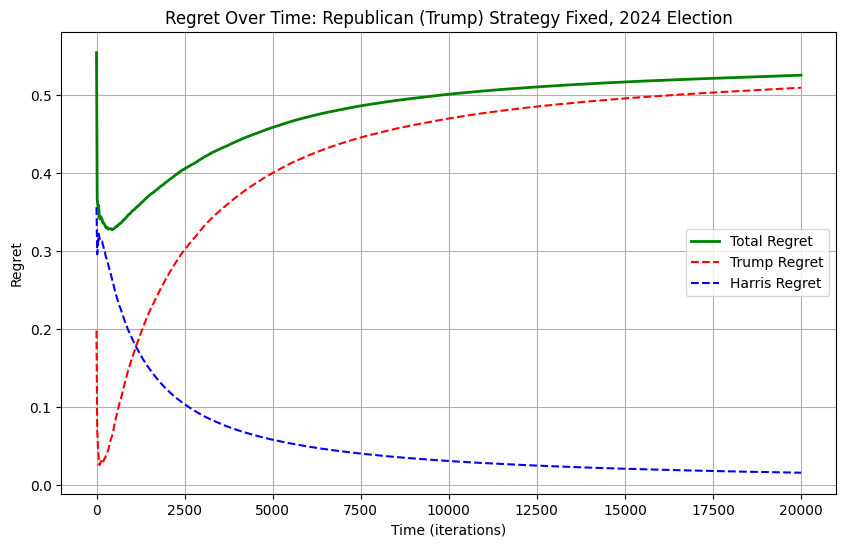

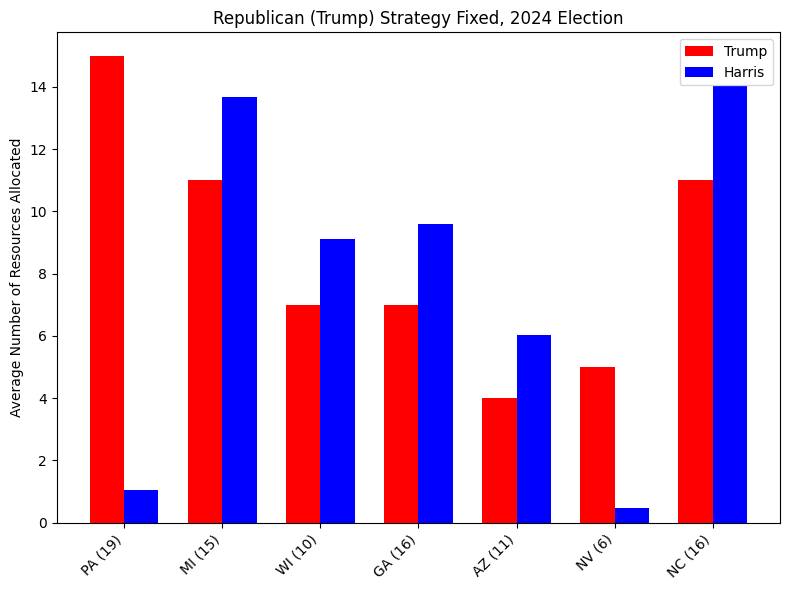

In [18]:
#Republican (Trump) Strategy Fixed
T = 20000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.electoral_vote
calc_d2e = False
fixed_strategy = np.array(fixed_trump)
ev_adv =  [0.0]*k
title = "Republican (Trump) Strategy Fixed, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix = title, suffix="electoral_votes_uniform")
plot_regret(game, title = title)
plot_avg_strat(game,swing_states,swap_players=False, title = title)

# Incomplete: Attempted Bias Implementation

Trump Strategy Fixed with Biased Weights

In [16]:
ev_adv = [2.7, 0.4, 1.9, 1.2, 5.5, 2.1, -2]

[ 2.7  0.4  1.9  1.2  5.5  2.1 -2. ]
Battles: 7
Soldiers: [60 54]
Values (rescaled): [19. 15. 10. 16. 11.  6. 16.]
Iterations: 1000
Final regret: nan
Runtime: 21.33371925354004 seconds
Player 0 final strategy allocation at iteration 1000: [15 11  7  7  4  5 11]
Player 1 final strategy allocation at iteration 1000: [ 5 12  4  6  1  1 25]

Average Allocations (All Iterations):
Player 0 average allocation: [15.015 11.011  7.007  7.007  4.004  5.005 11.011]
Player 1 average allocation: [7.466 7.568 7.996 8.001 8.038 7.822 7.163]

Distribution of Allocations for Player 0:
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    1.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    

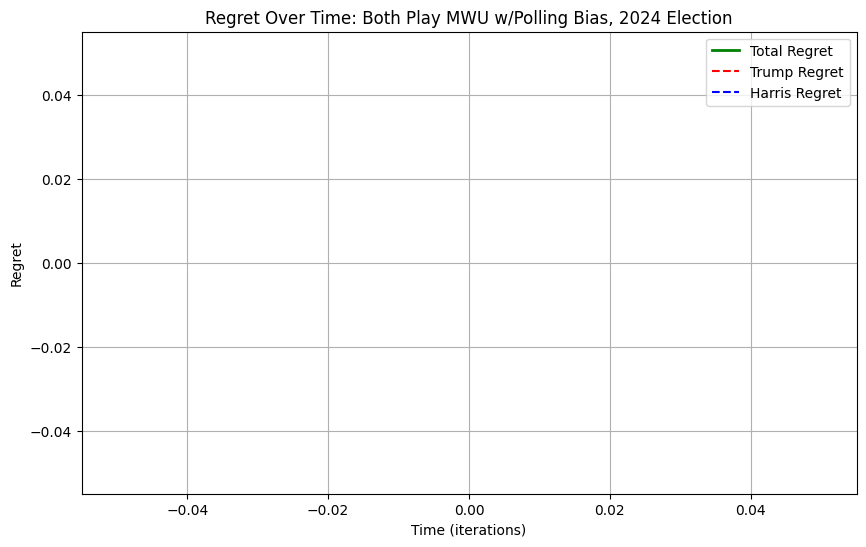

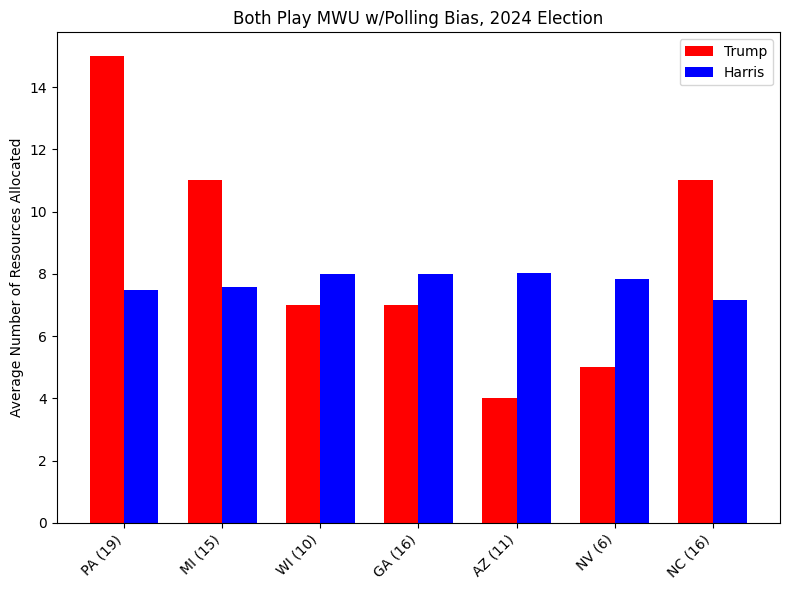

In [27]:
#Fixed Trump w biased weights
T = 1000
L = 2
k = 7
N = [60, 54]
W = ev
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.ev_adj
calc_d2e = False
fixed_strategy = np.array(fixed_trump)

margins = [1.7, 1.4, 0.9, 2.2, 5.5, 3.1, 3]
ev_adv = margins + (np.array(fixed_harris) - np.array(fixed_trump))
print(ev_adv)
title = "Both Play MWU w/Polling Bias, 2024 Election"

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix=title, suffix="adjusted_electoral_votes_uniform")
plot_regret(game,title)
plot_avg_strat(game,swing_states,title= title)

# Random Tests

Battles: 3
Soldiers: [20 20]
Values (rescaled): [1. 2. 3.]
Iterations: 200
Final regret: 0.2072968490878932
Runtime: 0.904545783996582 seconds
Player 0 final strategy allocation at iteration 200: [ 0  6 14]
Player 1 final strategy allocation at iteration 200: [8 7 5]

Average Allocations (All Iterations):
Player 0 average allocation: [5.025 6.635 8.44 ]
Player 1 average allocation: [5.01  6.465 8.625]

Distribution of Allocations for Player 0:
[[0.13  0.15  0.08  0.07  0.095 0.085 0.07  0.06  0.06  0.065 0.03  0.025
  0.015 0.005 0.03  0.015 0.01  0.01  0.    0.    0.   ]
 [0.06  0.06  0.105 0.11  0.065 0.08  0.065 0.09  0.07  0.04  0.035 0.035
  0.055 0.04  0.025 0.03  0.    0.025 0.    0.005 0.01 ]
 [0.045 0.05  0.045 0.065 0.045 0.08  0.065 0.06  0.065 0.06  0.05  0.05
  0.1   0.03  0.07  0.045 0.035 0.02  0.015 0.01  0.   ]]


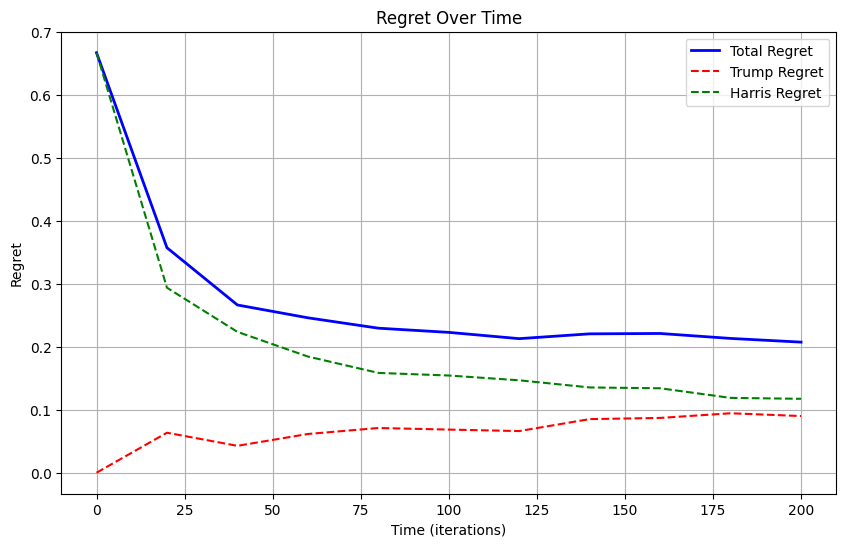

In [ ]:
#Vanila - 3 States, Equal Resources

import numpy as np

# Create an instance of CB with given parameters
T = 200
L = 2
k = 3
N = [20, 20]
W = [1.0, 2.0, 3.0]
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv = [0.0, 0.0, 0.0]

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix="test1_", suffix="zeroone_uniform")
plot_regret(game)

<ipython-input-3-a36cb37978e3>:406: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(denom==0,0.5, opp_mat/denom)


Battles: 5
Soldiers: [50 50]
Values (rescaled): [ 5.  5. 10. 20. 10.]
Iterations: 1000
Final regret: 1.001898101898102
Runtime: 17.317188024520874 seconds
Player 0 final strategy allocation at iteration 1000: [15  8  0 26  1]
Player 1 final strategy allocation at iteration 1000: [ 4  3  6 14 23]

Average Allocations (All Iterations):
Player 0 average allocation: [ 9.492  9.128 10.466 10.824 10.14 ]
Player 1 average allocation: [ 9.571  9.997  9.618 10.667 10.197]

Distribution of Allocations for Player 0:
[[0.075 0.065 0.078 0.061 0.069 0.065 0.044 0.045 0.04  0.045 0.027 0.052
  0.041 0.036 0.035 0.025 0.016 0.027 0.017 0.012 0.018 0.016 0.007 0.008
  0.011 0.007 0.01  0.011 0.007 0.003 0.004 0.006 0.002 0.005 0.003 0.
  0.001 0.002 0.001 0.    0.    0.001 0.002 0.    0.001 0.    0.    0.
  0.    0.    0.   ]
 [0.066 0.069 0.075 0.078 0.056 0.063 0.055 0.058 0.048 0.037 0.041 0.037
  0.036 0.029 0.039 0.03  0.031 0.016 0.018 0.011 0.017 0.01  0.01  0.01
  0.006 0.013 0.005 0.002 0.009

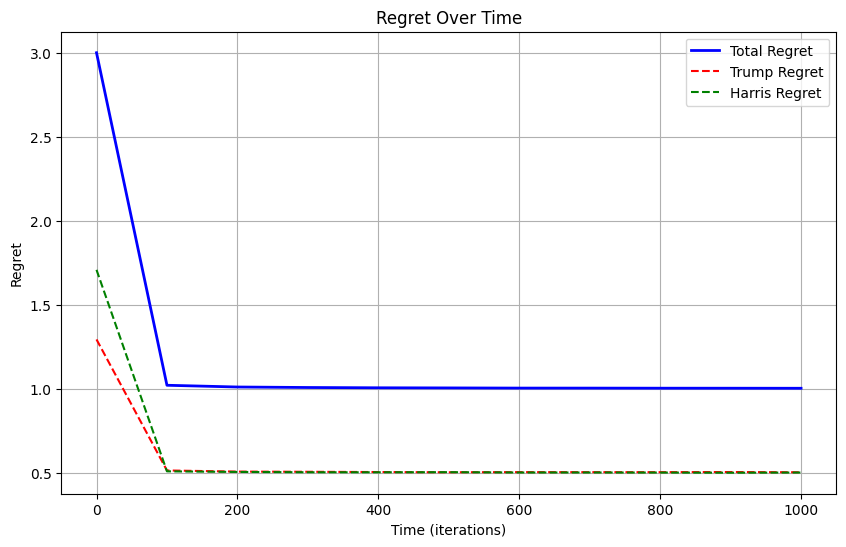

In [ ]:
import numpy as np

# Create an instance of CB with given parameters
T = 1000
L = 2
k = 5
N = [50, 50]
W = [5.0, 5.0, 10.0, 20.0, 10.0]
beta = 0.995
T0 = 100
tol = 0.02
optimistic = True
init = InitType.proportional
init_factor = 10
lt = LossType.popular_vote
calc_d2e = False
fixed_strategy = np.array([])
ev_adv = [0.0]*5

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix="test2_", suffix="popular_proportional")
plot_regret(game)

Battles: 2
Soldiers: [10 10]
Values (rescaled): [1. 1.]
Iterations: 50
Final regret: 1.0
Runtime: 0.02980184555053711 seconds
Player 0 final strategy allocation at iteration 50: [7 3]
Player 1 final strategy allocation at iteration 50: [2 8]

Average Allocations (All Iterations):
Player 0 average allocation: [4.36 5.84]
Player 1 average allocation: [5.18 5.02]

Distribution of Allocations for Player 0:
[[0.1  0.08 0.12 0.12 0.12 0.12 0.12 0.08 0.12 0.04 0.  ]
 [0.   0.04 0.12 0.08 0.12 0.12 0.12 0.12 0.12 0.08 0.1 ]]


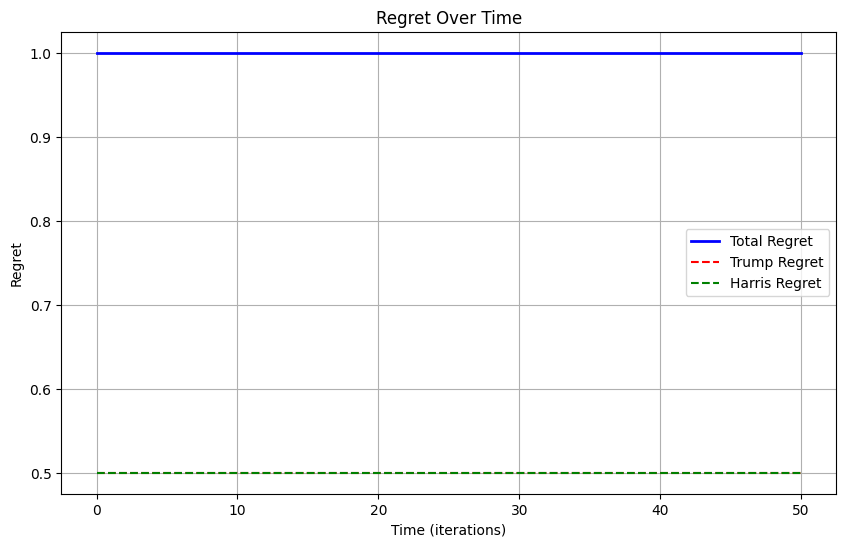

In [ ]:
import numpy as np

T = 50
L = 2
k = 2
N = [10,10]
W = [1.0,1.0]
beta = 0.9
T0 = 10
tol = 0.1
optimistic = False
init = InitType.three_halves
init_factor = 1
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv = [0.0, 0.0]

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix="test3_", suffix="zeroone_threehalves")
plot_regret(game)

Battles: 6
Soldiers: [20 20]
Values (rescaled): [10.  5.  7.  7. 10. 18.]
Iterations: 2000
Final regret: 0.04908072279649073
Runtime: 5.039983749389648 seconds
Player 0 final strategy allocation at iteration 2000: [6 3 4 5 1 1]
Player 1 final strategy allocation at iteration 2000: [4 1 4 0 2 9]

Average Allocations (All Iterations):
Player 0 average allocation: [3.447  1.4885 2.318  2.3705 3.578  6.808 ]
Player 1 average allocation: [3.453  1.563  2.3175 2.3185 3.3935 6.9645]

Distribution of Allocations for Player 0:
[[0.125  0.1355 0.127  0.12   0.1165 0.1375 0.1595 0.0595 0.014  0.004
  0.001  0.     0.0005 0.0005 0.     0.     0.     0.     0.     0.
  0.    ]
 [0.2655 0.2835 0.273  0.117  0.029  0.019  0.005  0.0035 0.004  0.0005
  0.     0.     0.0005 0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.1735 0.1705 0.2    0.2155 0.161  0.0485 0.018  0.007  0.0035 0.002
  0.0005 0.     0.     0.0005 0.     0.     0.     0.     0.     0.
  0.    ]
 [0.163  0.1725 0.2055 0.217

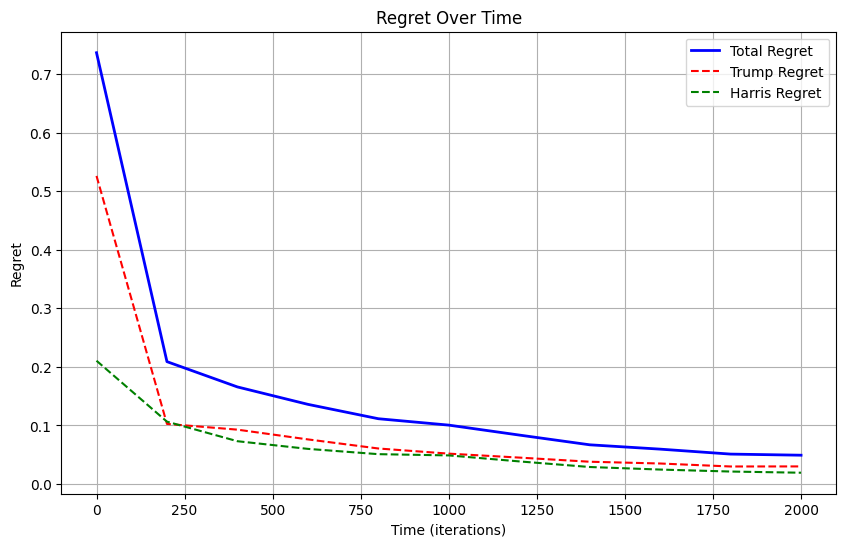

In [ ]:
import numpy as np

T = 2000
L = 2
k = 6
N = [20, 20]
W = [10.0, 5.0, 7.0, 7.0, 10.0, 18.0]
beta = 0.9
T0 = 200
tol = 0.05
optimistic = False
init = InitType.proportional
init_factor = 0
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv = [0.0]*k

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix="test4_", suffix="large_soldiers_zeroone")
plot_regret(game)

Battles: 5
Soldiers: [20 20]
Values (rescaled): [42. 68. 35.  1. 70.]
Iterations: 4480
Final regret: 0.049832833279609634
Runtime: 9.973561525344849 seconds
Player 0 final strategy allocation at iteration 4480: [ 3 12  3  0  2]
Player 1 final strategy allocation at iteration 4480: [ 2 13  2  0  3]

Average Allocations (All Iterations):
Player 0 average allocation: [3.65044643 6.296875   3.12366071 0.3703125  6.56316964]
Player 1 average allocation: [3.60625    6.39776786 3.03482143 0.36049107 6.60513393]

Distribution of Allocations for Player 0:
[[1.26562500e-01 1.34598214e-01 1.17410714e-01 1.11160714e-01
  1.04464286e-01 1.24330357e-01 1.32589286e-01 1.13392857e-01
  2.18750000e-02 5.80357143e-03 2.45535714e-03 2.67857143e-03
  1.33928571e-03 8.92857143e-04 2.23214286e-04 4.46428571e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.83035714e-02 6.67410714e-02 6.33928571e-02 7.47767857e-02
  7.96875000e-02 8.86160714e-02 7.76785714e-02 8.30357143

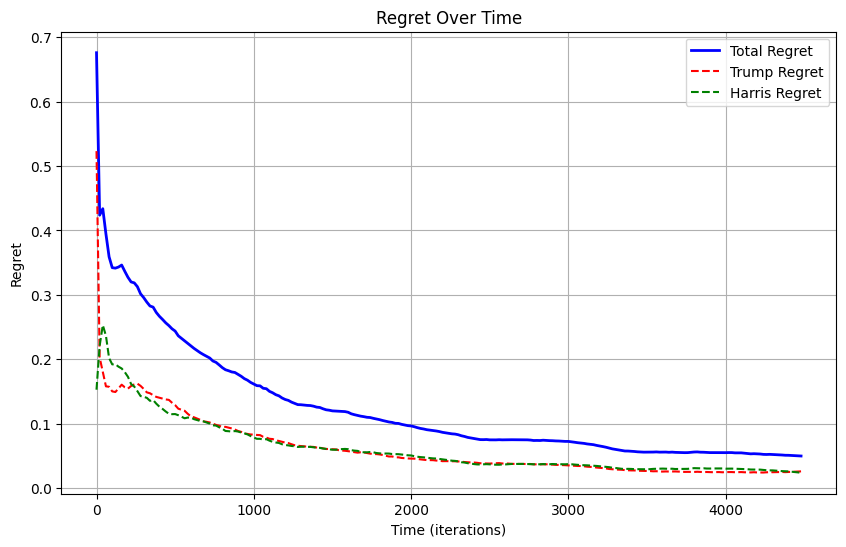

In [ ]:
import numpy as np

# Create an instance of CB with given parameters
T = 5000
L = 2
k = 5
N = [20, 20]
W = [42, 68, 35, 1, 70]
beta = 0.95
T0 = 20
tol = 0.05
optimistic = False
init = InitType.uniform
init_factor = 0
lt = LossType.zero_one
calc_d2e = False
fixed_strategy = np.array([])
ev_adv = [0.0, 0.0, 0.0]

game = CB(T, L, k, N, W, beta, T0, tol, optimistic, init, init_factor, lt, calc_d2e, fixed_strategy, ev_adv)
game.run_test(prefix="test1_", suffix="zeroone_uniform")
plot_regret(game)